# Рабочий ноутбук для решения задачи предсказания территории на которой находится торговая точка
### Для финального проекта курса “Специализация Data Science” (университет SkillFactory)
#### Сергей Пигида (группа DST-5, DST-0, 2020 год)

## Глоссарий
**Торговая точка** - индивидуальный предприниматель или организация осуществляющая продажу продукции Компапании конечному потребителю в оборудованном помещении по конкретному адресу.

**Дистрибьютор** - клиент Компании осуществляющий продажу товаров в торговые точки определенной географической территории. Дистрибьютор имеет по крайней мере один филиал и один офис.

**Код доставки** - код адреса доставки из корпоративной информационной системы Компании. Соответствует физическому складу. Обычно, один филиал имеет один адрес доставки, но может иметь и больше. В решаемой задаче код доставки - это целевой класс (поле SHIP_TO_RSS).

## Входные данные
Данные поступают из двух файлов, которые формируются в существующей системой отчетности. В процессе обработки файлы могут быть объединены по полю “Код торговой точки”.
#### Файл Coordinates.xlsx
Файл содержит координаты торговых точек. Не все торговые точки имеют координаты. В процессе подготовки данных для обучения модели, точкам без координат будут назначены усредненные координаты соседних точек, которые находятся в том-же населенном пункте, что и точка без координат.
#### Файл Report Territory Management.xlsx
Данный файл является специальным отчетом, который требуется для работы оператора процесса, а также является входным файлом для последующего расчета. Файл содержит следующую информацию по точкам:
- Иерархия дистрибьюторов (Регион - Дистрибьютор - Филиал)
- Иерархия сотрудников
- Адресный классификатор (пять уровней)
- Характеристики точки: Сеть, Тир, Сегмент, Формат и т.п.
- Информация о посещении точки
- Код филиала на территории которого находится торговая точка (этот код необходимо предсказать, если отсутствует)

## Анализ и подготовка данных

In [62]:
# Импорт библиотек
import pandas as pd
import numpy as np
import scipy
from scipy import sparse

import matplotlib as mpl
import matplotlib.pyplot as plt
# %matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import missingno as msno

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import mutual_info_classif

from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import mutual_info_classif
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

import category_encoders as ce

from pprint import pprint
from time import time
import re
import os
import pickle

coord_file = 'Coordinates.xlsx'
report_file = 'Report Territory Management.xlsx'

### Координаты точек

Посмотрим на файл с координатами точек. Видим, что в файле содержится 435 тысяч записей без пустых значений.

In [2]:
# Загрузка файла с кординатами в DataFrame
df_coor = pd.read_excel(coord_file)
df_coor.columns = ['SWE_Store_Key','Latitude','Longitude']
df_coor.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435419 entries, 0 to 435418
Data columns (total 3 columns):
SWE_Store_Key    435419 non-null int64
Latitude         435419 non-null float64
Longitude        435419 non-null float64
dtypes: float64(2), int64(1)
memory usage: 10.0 MB


Но что с валидностью значений? Необходимо учитывать, что допустимые значения широты находятся в диапазоне от -90 до +90, а значения долготы - в диапазоне от -180 до +180. Откинем недопустимые значения. Как видим, их не много.

In [3]:
# Оставить только допустимые координаты (широта -90...+90, долгота -180..+180)
init_num = df_coor.shape[0]
df_coor = df_coor[(df_coor['Latitude']>=-90) & (df_coor['Latitude']<=90)]
df_coor = df_coor[(df_coor['Longitude']>=-180) & (df_coor['Longitude']<=180)]
print(f'Валидных значений: {df_coor.shape[0]}, некорректных значений: {init_num - df_coor.shape[0]}')

Валидных значений: 435411, некорректных значений: 8


Беря во внимание информацию из Википедии о крайних точках Российской Федерации (https://ru.wikipedia.org/wiki/%D0%9A%D1%80%D0%B0%D0%B9%D0%BD%D0%B8%D0%B5_%D1%82%D0%BE%D1%87%D0%BA%D0%B8_%D0%A0%D0%BE%D1%81%D1%81%D0%B8%D0%B8), отбросим точки из других стран (берем с запасом). Осталось 396 тысяч точек с координатами

In [4]:
# Оставить только точки, с координатами в РФ
df_coor = df_coor[(df_coor['Latitude']>40)&(df_coor['Latitude']<82)]
df_coor = df_coor[((df_coor['Longitude']>=10)&(df_coor['Longitude']<180)) | \
    ((df_coor['Longitude']>=-180)&(df_coor['Longitude']<-160))]
print(f'Всего данных по точкам  в РФ: {df_coor.shape[0]}')

Всего данных по точкам  в РФ: 396144


Посмотрим на распределение значений на графике типа Box & Whiskers. Получается медианное значение широты 55, а для долготы 50, с очевидно значительно меньшим количеством точек на крайних границах, которые не являются выбросами, в данном случае. Распределение не нормальное.

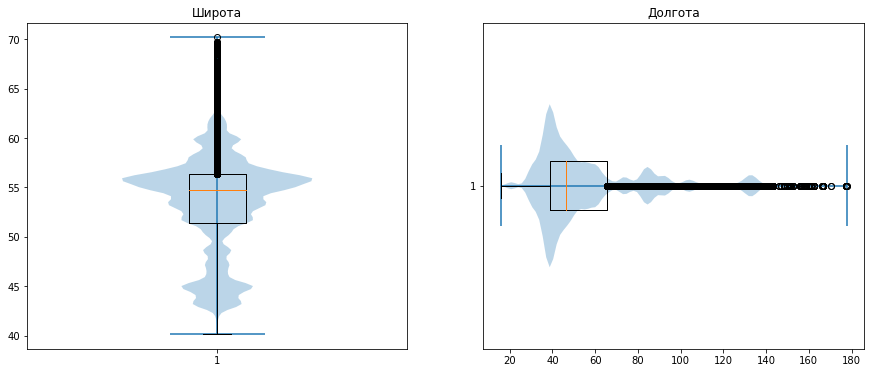

In [5]:
# Нарисовать графики типа Box & Whiskers плюс violinplot с визулальным распределением значений
fig, axes = plt.subplots(1,2, figsize=(15,6))
axes[0].violinplot(df_coor['Latitude'].values)
axes[0].boxplot(df_coor['Latitude'].values, whis=(0,1))
axes[0].set_title('Широта')
axes[1].violinplot(df_coor[df_coor['Longitude']>0]['Longitude'].values, vert=False)
axes[1].boxplot(df_coor[df_coor['Longitude']>0]['Longitude'].values, vert=False, whis=(0,1))
axes[1].set_title('Долгота')
plt.show()

In [6]:
# Детальная статистика по координатам точек
df_coor.describe()

,SWE_Store_Key,Latitude,Longitude
count,3.961440e+05,396144.000000,396144.000000
mean,1.014634e+14,53.448102,57.361018
std,1.236369e+12,5.054505,27.700726
min,1.000201e+09,40.166158,-179.118938
25%,1.000500e+14,51.364246,38.684879
50%,1.012700e+14,54.751350,46.110459
75%,1.027100e+14,56.305230,65.566879
max,1.044500e+14,70.167074,177.691300


### Информация по торговым точкам

Теперь перейдем к рассмотрению файла с основной информацией по торговым точкам. Как видно, информация по точке, полученная из справочников с основными мастер-данными, кажется полной (иерархия дистрибьюторов, иерархия сотрудников, информация по сети и точке, а также адресный классификатор), то есть признаки не содержат пропущенных значений.

In [7]:
# Загрузка файла с территориями точек в DataFrame и переименование столбцов для удобной работы
df_terr = pd.read_excel(report_file, skiprows=1)
df_terr.columns = ['Region','Distrib','Office','FFDSL','TSE_MTDE','Level_Torg_Region1','Level_Torg_Region2',
    'Filial_Name','Filial_Ship_To','Chain_Type','Chain_Name','Chain_Id','Chain_Chain_Tier_MWC',
    'Chain_Chain_Sub_Tier_MWC','SWE_Store_Key','Store_Status','Outlet_Name','Channel_Name_2018',
    'Outlet_Type_2018','Trade_Structure','From_Dc','Segment_MWC_Segment_Name','Cluster_MWC',
    'Kladr_level_1','Kladr_level_2','Kladr_level_3','Kladr_level_4','Kladr_level_5','LSV_WWY','LSV_CHOCO',
    'LSV_MWC','Covering_Outlet_id','General_Duplicate','Ship_To_Visited','Filial_Visited',
    'Ship_to_Name_TO_BE','Region_loaded_RSS','Ship_to_TO_BE_Name_loaded_RSS','SHIP_TO_RSS',
    'Ship_to_Code_TO_BE','DC','Changed','Change_Period']

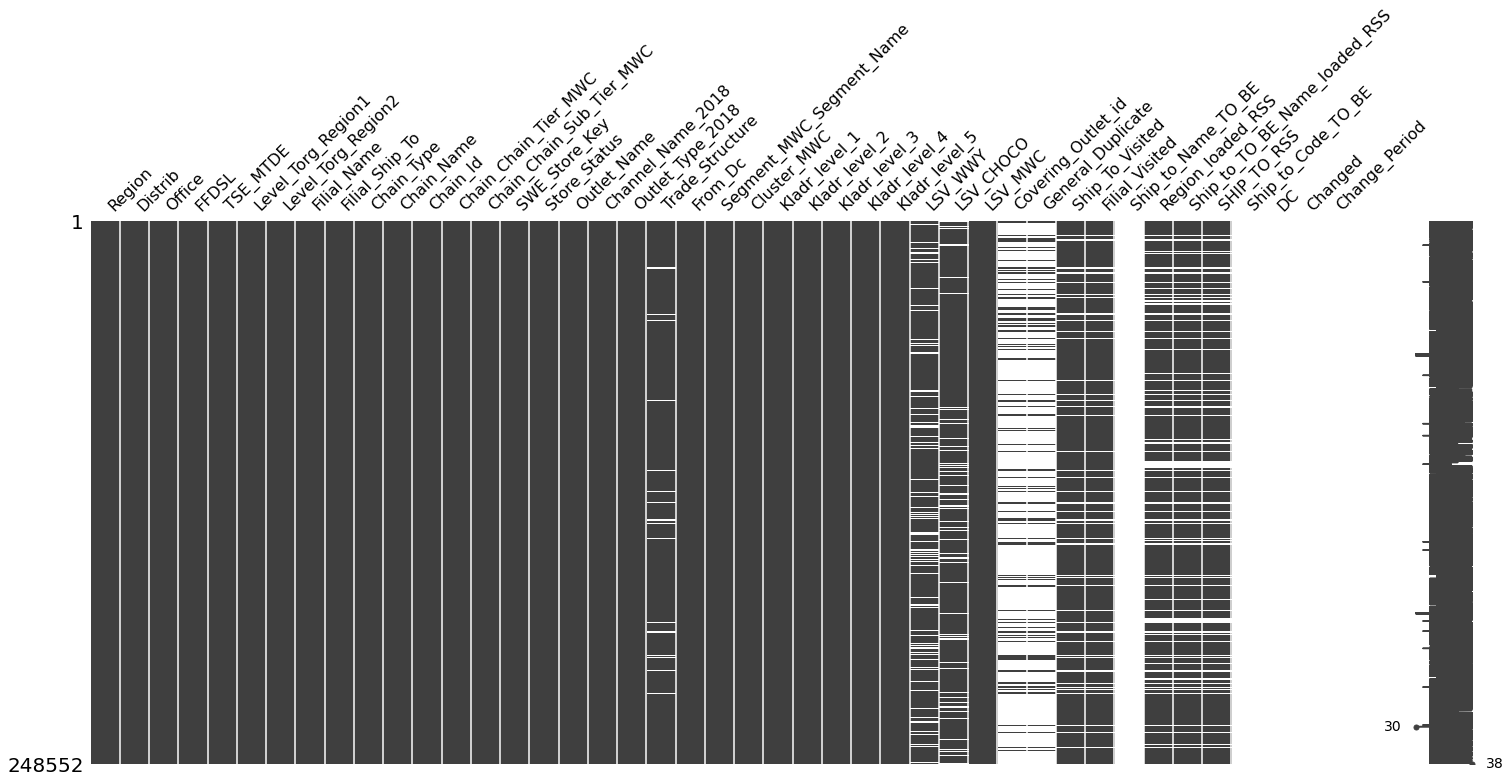

In [8]:
msno.matrix(df_terr)

Удалим поля с названиями, для которых имеются соответствующие коды, а также поля без значений. Также нужно убрать информацию об объеме продаж. Оставляем признак Ship_To_Visited с информацией о том, какой дистрибьютор сделал последний визит в точку (нам известно, что точку могут посещать несколько дистрибьюторов). Дальше нужно с ним внимательно поработать.

In [9]:
df_terr = df_terr[['SWE_Store_Key','Region','Distrib','Office','FFDSL','TSE_MTDE','Level_Torg_Region1',
    'Level_Torg_Region2','Filial_Name','Filial_Ship_To','Chain_Type','Chain_Id','Chain_Chain_Tier_MWC',
    'Chain_Chain_Sub_Tier_MWC','Channel_Name_2018','Outlet_Type_2018','Trade_Structure','From_Dc',
    'Segment_MWC_Segment_Name','Cluster_MWC','Covering_Outlet_id','General_Duplicate','Ship_To_Visited',
    'SHIP_TO_RSS','Kladr_level_1','Kladr_level_2','Kladr_level_3','Kladr_level_4','Kladr_level_5']]

Также от бизнеса получена информация, что в данных содержится информация о точках-дубликатах и определен способ оставить только основные (актуальные) точки

In [10]:
df_terr = df_terr[df_terr['General_Duplicate']!='Дубликат']
df_terr.drop(['Covering_Outlet_id','General_Duplicate'], axis=1, inplace=True)

Объединим отчет по территориям с координатами.

In [11]:
df = pd.merge(df_terr, df_coor, on='SWE_Store_Key', how='left')
# del df_terr
# del df_coor

Поскольку для каждой точки известен адрес, можно воспользоваться этой информацией, чтобы приблизительно восстановить координаты для точек с отсутствующими координатами. Для этого с бизнесом согласован алгоритм, при котором точкам без координат будут назначены усредненные координаты соседних точек, которые находятся в том-же населенном пункте, что и точка без координат. В случае отсутствия соседей в населенном пункте будет использоваться более высокий уровень адресного классификатора. После этого можно избавиться от адресного классификатора.

In [12]:
%%time
df['Latitude'].replace(0, np.NaN, inplace=True)
df['Longitude'].replace(0, np.NaN, inplace=True)
df['isCoord'] = ~( (df['Latitude'].isna()) | (df['Longitude'].isna()) )

kladr_lat_grouped = df[df['isCoord']==1].groupby(['Kladr_level_1','Kladr_level_2','Kladr_level_3','Kladr_level_4']).Latitude.mean()
kladr_lon_grouped = df[df['isCoord']==1].groupby(['Kladr_level_1','Kladr_level_2','Kladr_level_3','Kladr_level_4']).Longitude.mean()


def get_avg_coordinate(row, kladr_grouped):
    """
    Вернуть среднюю координату населенного пункта, области, региона или страны. Используем функции
    multiindex.isin().any(), чтобы проверить, что в Series имеется индекс для всех 4-х уровней
    и вернуть значение. В случае отсутствия индекса, отрубить последний уровень в индексе и проверить
    индекс для 3-х уровней и т.д.

    Parameters:
    row (Series): ['Kladr_level_1','Kladr_level_2','Kladr_level_3','Kladr_level_4'] для которых нужно
        получить координату
    kladr_grouped (Series): с мультииндексом (['Kladr_level_1','Kladr_level_2','Kladr_level_3','Kladr_level_4'])
        который содержит значения координаты для 4-х уровней из адресного классификатора
        
    Returns:
    float: Координата

    """
    try:
        if kladr_grouped.index \
                .isin([(row['Kladr_level_1'],row['Kladr_level_2'],row['Kladr_level_3'],row['Kladr_level_4'])]).any():
            return kladr_grouped[row['Kladr_level_1'],row['Kladr_level_2'],row['Kladr_level_3'],row['Kladr_level_4']]
        elif kladr_grouped.index.droplevel(['Kladr_level_4']) \
                .isin([(row['Kladr_level_1'],row['Kladr_level_2'],row['Kladr_level_3'])]).any():
            return kladr_grouped[row['Kladr_level_1'],row['Kladr_level_2'],row['Kladr_level_3']].mean()
        elif kladr_grouped.index.droplevel(['Kladr_level_3','Kladr_level_4']) \
                .isin([(row['Kladr_level_1'],row['Kladr_level_2'])]).any():
            return kladr_grouped[row['Kladr_level_1'],row['Kladr_level_2']].mean()
        elif kladr_grouped.index.droplevel(['Kladr_level_2','Kladr_level_3','Kladr_level_4']) \
                .isin([(row['Kladr_level_1'])]).any():
            return kladr_grouped[row['Kladr_level_1']].mean()
        else:
            return 0
    except:
        print(row['Kladr_level_1'],row['Kladr_level_2'],row['Kladr_level_3'],row['Kladr_level_4'])
        raise KeyError


df.loc[df['isCoord']==0,'Latitude'] = \
    df.loc[df['isCoord']==0][['SWE_Store_Key','Kladr_level_1','Kladr_level_2','Kladr_level_3','Kladr_level_4']].apply( \
        get_avg_coordinate, args=(kladr_lat_grouped,), axis=1)

df.loc[df['isCoord']==0,'Longitude'] = \
    df.loc[df['isCoord']==0][['SWE_Store_Key','Kladr_level_1','Kladr_level_2','Kladr_level_3','Kladr_level_4']].apply( \
        get_avg_coordinate, args=(kladr_lon_grouped,), axis=1)

Wall time: 3min 25s


In [13]:
df.drop(['Kladr_level_1','Kladr_level_2','Kladr_level_3','Kladr_level_4','Kladr_level_5'], axis=1, inplace=True)
df['isTrain'] = ~ df['SHIP_TO_RSS'].isna()

In [14]:
df_init = df.copy()

### Анализ целевой переменной SHIP_TO_RSS

Поскольку целевой признак SHIP_TO_RSS это не непрерывная величина, а возможные фиксированные значения, то наша задача сводится к задаче мультиклассовой классификации. Нужно обучить модель показывать наиболее вероятный код SHIP_TO_RSS по входным признакам. Доля точек с неизвестным целевым признаком - примерно 10%.

In [15]:
# Посчитать длину поля SHIP_TO_RSS, сгруппировать по длине и вывести первое значение из каждой группы
ship = df[['SHIP_TO_RSS']]
ship.loc[~ship['SHIP_TO_RSS'].isna(),'Length'] = \
    ship.loc[~ship['SHIP_TO_RSS'].isna()].SHIP_TO_RSS.apply(lambda x: len(str(x).strip()))
ship.groupby('Length').SHIP_TO_RSS.first()

Length
8.0                            10340352
19.0                10342443 , 10430024
30.0     10262975 , 10428588 , 10432783
Name: SHIP_TO_RSS, dtype: object

Задан вопрос бизнесу, почему для некоторых точек идёт два или три кода доставки, и получен ответ, что нужно использовать только первый код.

In [16]:
# SHIP_TO_RSS взять первые 8 символов и преобразовать к типу str
df.loc[~df['SHIP_TO_RSS'].isna(),'SHIP_TO_RSS'] = \
    df.loc[~df['SHIP_TO_RSS'].isna()]['SHIP_TO_RSS'].apply(lambda x: str(x).strip()[:8])

Построим гистограмму распределения количества кодов доставки по частоте количества точек на территории. Видно, что  выборка данных является несбалансированной.

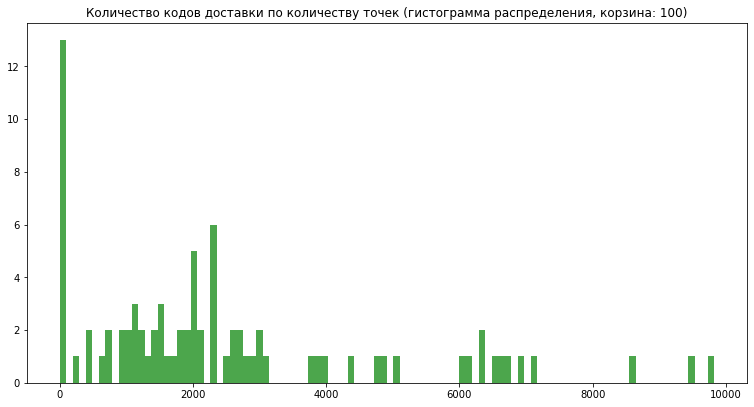

In [17]:
# Посчитаем количество точек по классам
ship_counts = df[~df['SHIP_TO_RSS'].isna()].groupby('SHIP_TO_RSS').size().to_frame()
ship_counts.reset_index(inplace=True)
ship_counts.columns = ['SHIP_TO_RSS','Counts']

fig = plt.figure(figsize=(10,5))
axes = fig.add_axes([0, 0, 1, 1])
bins = 100
axes.hist(x = ship_counts['Counts'].values,
        bins = bins,
        color ='green',
        alpha = 0.7)
axes.set_title(f'Количество кодов доставки по количеству точек (гистограмма распределения, корзина: {bins})')
plt.show()

Видно, что имеется 13 кодов доставки с количеством точек меньшим 100. Бизнес говорит, что у с одного адреса доставки не может грузиться так мало точек. Необходимо проверить, что модель может предсказывать класс на малом количестве точек. Согласовали подход: проанализировать точность модели при предсказывании класса с малым количеством сэмплов и, в случае, необходимости, сообщать пользователю о наличии классов с недостаточным количеством точек, но не "угадывать" класс (исключать такие классы из обучения модели).

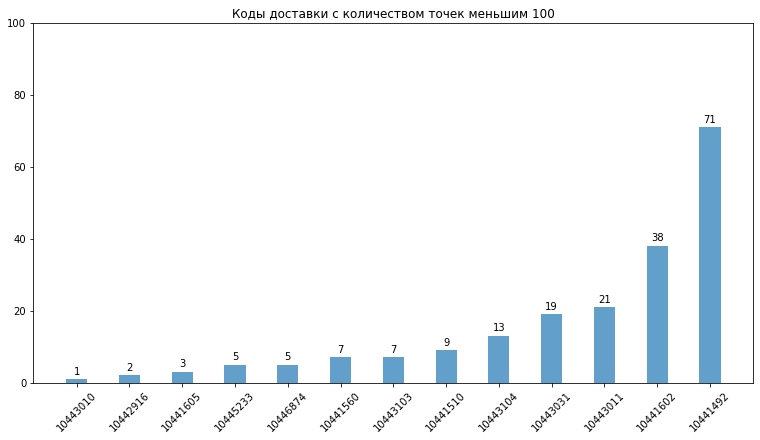

In [18]:
fig = plt.figure(figsize=(10,5))
axes = fig.add_axes([0, 0, 1, 1])
axes.set_ylim(0, 100)
threshold = 100
df_aux = ship_counts[ship_counts['Counts']<threshold].sort_values('Counts', ascending=True)
rects=axes.bar(x = df_aux['SHIP_TO_RSS'].values.astype('str'),
           height = df_aux['Counts'].values, 
           width = 0.4,
           align = 'center',
           alpha = 0.7)
for tick in axes.get_xticklabels():
    tick.set_rotation(45)
for rect in rects:
    h = rect.get_height()
    axes.annotate('%.0f' % (h),
                xy=(rect.get_x() + rect.get_width() / 2, h),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')
axes.set_title(f'Коды доставки с количеством точек меньшим {threshold}')
plt.show()

В данных присутствует код Ship_To_Visited очень похожий на SHIP_TO_RSS. Действительно, смысл кода один и тот-же, но есть важное отличие: это код того филиала дистрибьютора, который __последний__ посетил торговую точку. Знаем, что одну и ту же точку могут посещать разные дистрибьюторы. Отформатируем этот признак и посмотрим совпадения с целевой переменной.

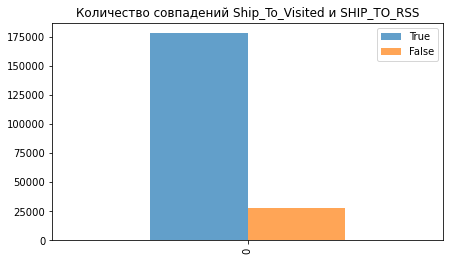

Несовпадение кодов наблюдается в 13.7% случаев


In [19]:
df.loc[~df['Ship_To_Visited'].isna(),'Ship_To_Visited'] = \
    df.loc[~df['Ship_To_Visited'].isna()]['Ship_To_Visited'].apply(lambda x: str(x).strip()[:8])

matching = df[~df['SHIP_TO_RSS'].isna()]['Ship_To_Visited']==df[~df['SHIP_TO_RSS'].isna()]['SHIP_TO_RSS']
matching.value_counts().to_frame().T.plot(kind='bar', figsize=(7,4), alpha=0.7,
                                          title='Количество совпадений Ship_To_Visited и SHIP_TO_RSS')
plt.show()
vc = matching.value_counts()
print(f'Несовпадение кодов наблюдается в {vc[False]/(vc[False]+vc[True])*100:.1f}% случаев')

### Анализ пропущенных значений

Посмотрим внимательнее на признаки, сразу замечаем присутствие значений "!ERR". Выясняем с бизнесом. Оказывается, из отчетной системы выгружаются значения !ERR если иерархия отсутствует.

In [20]:
df['Region'].value_counts()

South         44948
Volga         33893
Siberia       32200
East          25373
Ural          23755
North-West    23739
!ERR          20071
Moscow        17724
Name: Region, dtype: int64

Представим значения !ERR как NaN и посмотрим статистики по пропущенным значениям.

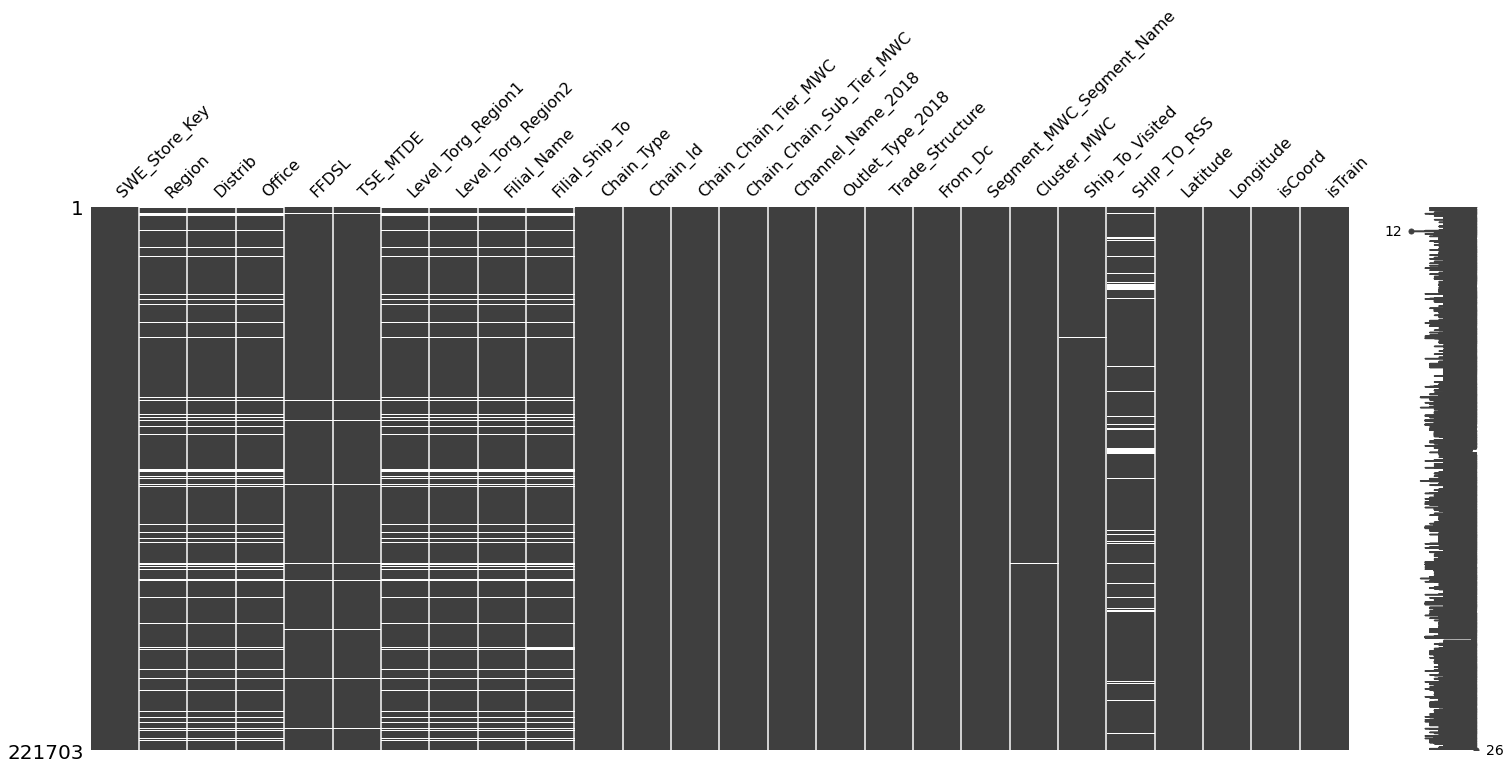

In [21]:
df.replace('!ERR', np.NaN, inplace=True)
msno.matrix(df)

Оценим пропуски количественно, для этого создадим таблицу некоторых статистик для всех признаков.

In [22]:
df_stats = pd.DataFrame(columns = ['column', 'values', 'num_unique', 'num_nan', 'pct_nan'])
tmp = pd.DataFrame()

for c in df.columns:
    tmp['column'] = [c]
    tmp['values'] = [df[c].unique()]
    tmp['num_unique'] = len(list(df[c].unique()))
    tmp['num_nan'] = df[c].isnull().sum()
    tmp['pct_nan'] = round(df[c].isnull().sum() / df.shape[0] * 100, 1)
    df_stats = df_stats.append(tmp)
    
df_stats[['column','values','num_unique','num_nan','pct_nan']]

,column,values,num_unique,num_nan,pct_nan
0,SWE_Store_Key,"[1000201031, 100050000000002, 100050000000031,...",221703,0,0.0
0,Region,"[Siberia, North-West, nan, Moscow, Ural, Volga...",8,20071,9.1
0,Distrib,"[ООО Гермес, ЗАО Денди, SF Мегаполис, nan, ООО...",62,20018,9.0
0,Office,"[MWC ООО Гермес (Новокузнецк), MWC Денди ЗАО, ...",168,20018,9.0
0,FFDSL,"[MWC FFDL Kuzbass (Vetrova Marina), MWC FFDL S...",39,4499,2.0
0,TSE_MTDE,"[MWC TSE Novokuznetsk (Sandler Kseniya), MWC T...",359,4499,2.0
0,Level_Torg_Region1,"[TL MWC: Север Кузбасса (Мокроусов Илья), TL: ...",521,20018,9.0
0,Level_Torg_Region2,[Агент МарсРигли-08 (Киселевск-2)(Погребных А....,2529,20018,9.0
0,Filial_Name,"[MWC ООО Гермес (Новокузнецк), MWC Денди ЗАО, ...",106,20019,9.0
0,Filial_Ship_To,"[10340352, 10407751, 10407053, nan, 10399270, ...",97,21163,9.5


Проверка того, как работает отчетная система отдела продаж, из которой получен отчет по точкам, показывает, что иерархия сотрудников компании (FFDSL, TSE_MTDE) задается отдельно от иерархии дистрибьюторов (куда попадают также торговые агенты Level_Torg_). Это подтверждает также совпадение количества пропущенных значений (примерно 9% для иерархии дистрибьюторов и 2% для иерархии сотрудников).

Чтобы подтвердить это предположение, построем тепловую карту корреляции пропущенных значений. По ней видно, что наличие пропущенных значений в признаках иерархии дистрибьютора (Distrib, Office, Level_Torg_Region1, Level_Torg_Region1, Filial_Name, Filial_Ship_To) имеет прямую корреляцию (значение 1). Также коррелирует появление пропущенных значений для признаков иерархии сотрудников (FFDSL и TSE_MTDE). Корреляция между этими двумя группами признаков существует, но в незначительной степени.

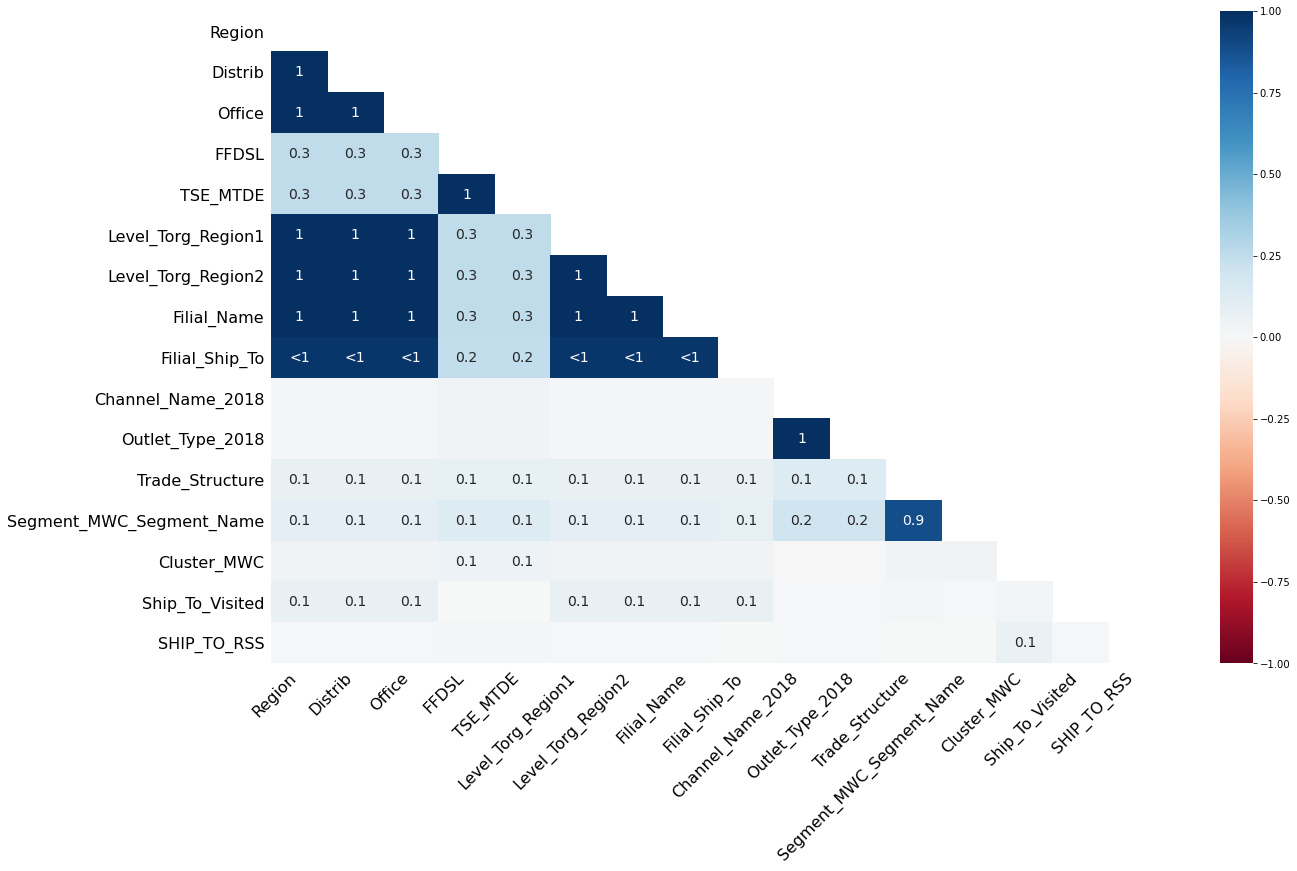

In [23]:
msno.heatmap(df)

### Сохраним текущий набор данных для дальнейших экспериментов

In [24]:
df['From_Dc'] = df['From_Dc'].astype(int)
df['Chain_Id'] = df['Chain_Id'].astype(str)
# Установить поле как индекс, тем самым исключив его из списка признаков
df.set_index('SWE_Store_Key',inplace=True)
df_for_experiments = df.copy()

## Получение модели и проведение экспериментов

### Выбор метрики

Для мультиклассовой классификации, в условиях несбалансированной выборки, допустимо использовать несколько различных метрик https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics. Для нашей задачи будем использовать метрику balanced_accuracy_score, которая определяется как средняя величина полноты (recall), полученная по каждому классу.

В случае, если классификатор работает одинаково хорошо для всех классов, то эта метрика работает как обычная точность, то есть отношение правильных предсказаний к общему количеству предсказаний. Если же обычная точность выше вероятности только потому, что классификатор использует несбалансированный набор тестов, тогда сбалансированная точность, в зависимости от ситуации, снизится до 1/n_classes (https://scikit-learn.org/stable/modules/model_evaluation.html#balanced-accuracy-score).

### Выбор базового классификатора для экспериментов
Для задачи классификации удобно использовать классификатор RandomForestClassifier. По моему опыту этот ансамблевый метод быстрый и часто показывает лучшие результаты обучения. Согласно Википедии этот алгоритм https://ru.wikipedia.org/wiki/Random_forest#%D0%94%D0%BE%D1%81%D1%82%D0%BE%D0%B8%D0%BD%D1%81%D1%82%D0%B2%D0%B0 имеет следующие достоинства:
- Способность эффективно обрабатывать данные с большим числом признаков и классов.
- Нечувствительность к масштабированию (и вообще к любым монотонным преобразованиям) значений признаков.
- Одинаково хорошо обрабатываются как непрерывные, так и дискретные признаки.

Будем использовать RandomForestClassifier для экспериментов, а потом сравним его с другими классификаторами

In [25]:
rfc = RandomForestClassifier(n_estimators=10, random_state=42, n_jobs=-1)

### Разделение на тренировочную и валидационную выборку

Функция get_data делит данные на тренировочную и валидационную выборку в соотношении 70 на 30 с контролем стратификации по целевой переменной (чтобы обеспечить попадание целевых значений и в тренировочную и валидационную выборки). При этом определяются (функцией get_ships_to_exclude) и отбрасываются классы в которых меньше двух сэмплов (в противном случае будет ошибка при разделении).

In [26]:
def get_ships_to_exclude(df, threshold=2):
    """
    Вернуть список классов с количеством сэмплов меньшим threshold
   
    """
    if threshold < 2:
        threshold = 2
    ship_counts = df[~df['SHIP_TO_RSS'].isna()].groupby('SHIP_TO_RSS').size().to_frame()
    ship_counts.reset_index(inplace=True)
    ship_counts.columns = ['SHIP_TO_RSS','Counts']
    
    return [str(item) for item in list(ship_counts['SHIP_TO_RSS'][ship_counts['Counts']<threshold].values)]


def get_encoded(X, y, ordinal=True):
    """
    Преобразует категорийные признаки в OrdinalEncoder, а целевую переменную в LabelEncoding
    
    """
    cat_features = X.select_dtypes(include=['object']).columns  # Categorical
    num_features = X.select_dtypes(exclude=['object']).columns  # Numeric
    
    if ordinal:
        # Преобразование категорийных признаков
        oe = OrdinalEncoder()
        X_cat = oe.fit_transform(X[cat_features])
        # Преобразование числовых признаков (не выполняем)
        X_num = X[num_features]
        # scaler = MinMaxScaler()
        # scaler.fit(X[num_features])
        # X_train_num = scaler.transform(X_train[num_features])
        # X_valid_num = scaler.transform(X_valid[num_features])
        # Объединить категорийные и числовые
        X_enc = np.hstack([X_cat, X_num])
    else:
        # OneHot
        ohe = OneHotEncoder(handle_unknown='ignore')
        X_cat = ohe.fit_transform(X[cat_features])
        # Преобразование числовых признаков (не выполняем)
        X_num = X[num_features]
        X_enc = scipy.sparse.hstack([X_cat, X_num])
    # Преобразование y
    le = LabelEncoder()
    y_enc = le.fit_transform(y)

    return X_enc, y_enc 


def get_data(drop_na=True, list_of_features=None, samples_threshold=2, get_data_info=False,
             do_encode=False, ordinal=True):
    """
    Получить наборы данных
    
    Parameters:
    drop_na (boolean)        : True - удалить строки с пустыми значениями, False - выполнить замену пропусков
    list_of_features (list)  : Список признаков, которые нужно оставить
    samples_threshold (int)  : Удалить классы с количеством сэмплов меньше чем samples_threshold
        
    Returns:
    X, y, X_train, X_valid, y_train, y_valid (array-like)

    """
    df = df_for_experiments.copy()

    cat_features = df.select_dtypes(include=['object']).columns  # Categorical
    num_features = df.select_dtypes(exclude=['object']).columns  # Numeric

    # Временно заменяем пропущенные значения
    df['SHIP_TO_RSS'].replace(np.NaN, 0, inplace=True)
    if drop_na:
        # Очистка строк с пропущенными значениями
        df.dropna(axis=0, inplace=True)
    else:
        # Замена пропущенных значений
        for name in cat_features:
            df[name].fillna('missing', inplace=True)
        for name in num_features:
            df[name].fillna(0, inplace=True)
    df['SHIP_TO_RSS'].replace(0, np.NaN, inplace=True)

    target = ['SHIP_TO_RSS']         # Целевая переменная
    service = ['isTrain','isCoord']  # Сервисные признаки, которые отбросить
    # Из полного списка признаков или из переданного списка признаков исключить target & service
    features = [column for column in \
                    (df.columns if list_of_features==None else list_of_features) \
                    if column not in target and column not in service]
    # Классы для исключения
    ships_to_exclude = get_ships_to_exclude(df, samples_threshold)
    # Вернуть наборы данных с нужными признаками и оставшимися классами
    X = df[(df['isTrain']==True)&(~df['SHIP_TO_RSS'].isin(ships_to_exclude))][features]
    y = df[(df['isTrain']==True)&(~df['SHIP_TO_RSS'].isin(ships_to_exclude))][target]
    y['SHIP_TO_RSS'] = y['SHIP_TO_RSS'].astype(int)
    
    if do_encode:
        # Выполнить кодирование признаков
        X, y = get_encoded(X, y, ordinal)
    
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    if get_data_info:
        print(f'Размер выборки total: {X.shape[0]}, train: {X_train.shape[0]}, valid: {X_valid.shape[0]}')
        print(f"Количество признаков: {len(features)} ({', '.join(features)})")
    
    return X, y, X_train, X_valid, y_train, y_valid

### Эксперимент. Отбор признаков

Для первичного отбора признаков воспользуемся функцией mutual_info_classif из sklearn.feature_selection, которая определяет важность признаков, вычисляя взаимную информацию. Взаимная информация рассчитывается между двумя переменными и измеряет уменьшение неопределенности для одной переменной при известном значении другой переменной.
https://machinelearningmastery.com/information-gain-and-mutual-information

mutual_info_classif() function https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_classif.html

In [27]:
encoder = OrdinalEncoder()
X, y, X_train, X_valid, y_train, y_valid = get_data(drop_na=False)
# Обучить энкодер и трансформировать признаки
encoder.fit(X)
X_train_enc = encoder.transform(X_train)
fs = mutual_info_classif(X_train_enc, y_train, random_state=42)

Оставим самые важные признаки, отбросив признаки с важностью менее 20% от самого важного и визуализируем

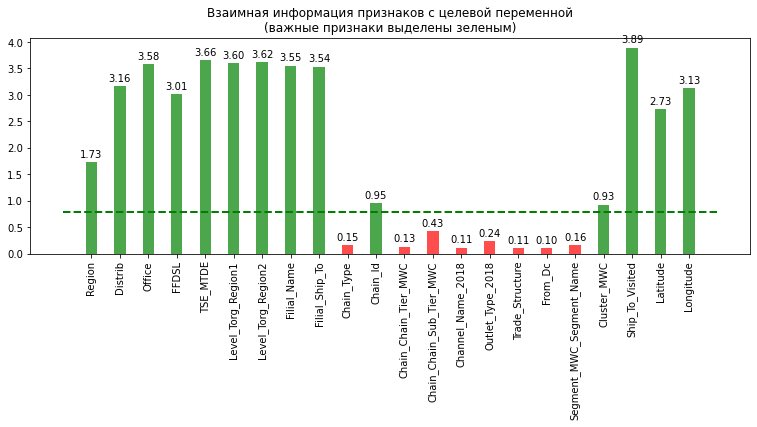

Важные признаки: Region, Distrib, Office, FFDSL, TSE_MTDE, Level_Torg_Region1, Level_Torg_Region2, Filial_Name, Filial_Ship_To, Chain_Id, Cluster_MWC, Ship_To_Visited, Latitude, Longitude


In [28]:
def get_important_features(feature_importance, threshold=0.2, do_show=True):
    """
    Из списка признаков и списка важности этих признаков отбросить threshold % несущественных,
    вернуть список важных признаков и нарисовать красивый график
    
    Parameters:
    feature_importance (dict)      : Словарь, который содержит {'features':(list), 'importance':(list)}
    threshold (float)              : Пороговое значение для отсечения неважных признаков
    do_show (bool)                 : Показать график
    
    """
    relative_threshold = feature_importance['importance'].max() * threshold
    selected_features = []
    for feat, score in zip(feature_importance['features'], feature_importance['importance']):
        if score > relative_threshold:
            selected_features.append(feat)
    if do_show:
        # График
        fig = plt.figure(figsize=(10,3))
        axes = fig.add_axes([0, 0, 1, 1])
        axes.set_title('Взаимная информация признаков с целевой переменной\n(важные признаки выделены зеленым)')

        # Зададим цвета важных и прочих признаков
        mask = feature_importance['importance'] < relative_threshold
        colors = np.array(['g']*len(feature_importance['importance']))
        colors[mask] = 'r'
        # График
        rects = axes.bar(x = feature_importance['features'],
                 height = feature_importance['importance'],
                 width = 0.4, alpha = 0.7, color=colors)
        # Повернуть названия признаков
        for tick in axes.get_xticklabels():
            tick.set_rotation(90)

        for rect in rects:
            h = rect.get_height()
            axes.annotate(f'{h:.2f}',
                        xy=(rect.get_x() + rect.get_width() / 2, h),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')
        # Нарисовать линию
        plt.plot([-1,len(feature_importance['features'])], [relative_threshold,relative_threshold],
                 color='green', linestyle='dashed', linewidth=2)
        plt.show()
    
    return selected_features


# Создадим словарь 
mic_feature_importance = {'features':list(X_train.columns), 'importance':fs}
mic_selected_features = get_important_features(mic_feature_importance, 0.2, True)
print(f"Важные признаки: {', '.join(mic_selected_features)}")

### Оценка модели

Для обучения и валидации модели используем процедуру get_model, которая реализует конвейер данных (Pipeline) в котором выполняется замена пропущенных значений, а также кодирование в соответствии с заданным энкодером.

In [29]:
def get_prediction_result(X, X_train, X_valid, y_valid, y_pred, hierarchy=True):
    """
    Строит сводную таблицу для количественного анализа предсказаний модели

    Parameters:
    X (array-like)      : Исходный набор признаков без целевого
    X_train (array-like): Набор признаков для обучения
    X_valid (array-like): Набор признаков для валидации
    y_valid (array-like): Целевой признак для валидации
    hierarchy (boolean) : True - включать в анализ расчеты по иерархиям
        
    Returns:
    pandas.DataFrame    : Сводная таблица

    """
    rdf = pd.DataFrame()

    # Сколько всего записей в тестовом наборе данных
    test = X.copy()
    test['SHIP_TO_RSS'] = y['SHIP_TO_RSS']
    test.groupby('SHIP_TO_RSS').SHIP_TO_RSS.count()
    rdf['SHIP_TO_RSS'] = test.groupby('SHIP_TO_RSS').SHIP_TO_RSS.count()
    rdf.columns = ['test_samples_counts']

    # Подсчитаем записи в тренировочном наборе
    train = X_train.copy()
    train['SHIP_TO_RSS'] = y_train['SHIP_TO_RSS']
    train_df = train.groupby('SHIP_TO_RSS').SHIP_TO_RSS.count().to_frame()
    train_df.columns = ['train_samples_counts']
    rdf.loc[train_df.index,'train_samples_counts'] = \
        train_df['train_samples_counts']

    # Подсчитаем записи в валидационном наборе
    valid = X_valid.copy()
    valid['SHIP_TO_RSS'] = y_valid['SHIP_TO_RSS']
    valid_df = valid.groupby('SHIP_TO_RSS').SHIP_TO_RSS.count().to_frame()
    valid_df.columns = ['valid_samples_counts']
    rdf.loc[valid_df.index,'valid_samples_counts'] = \
        valid_df['valid_samples_counts']

    # Подсчитаем количество ошибочных предсказаний
    y_comp = y_valid.copy()
    y_comp['SHIP_TO_RSS_PRED'] = y_pred
    y_wrong = y_comp[y_comp['SHIP_TO_RSS']!=y_comp['SHIP_TO_RSS_PRED']]
    y_wrong_df = y_wrong.groupby('SHIP_TO_RSS').SHIP_TO_RSS.count().to_frame()
    y_wrong_df.columns = ['wrong_predicted_counts']
    rdf.loc[y_wrong_df.index,'wrong_predicted_counts'] = \
        y_wrong_df['wrong_predicted_counts']

    # Ошибка в процентах от количества записей в проверочном наборе данных
    rdf['wrong_predicted_percentage'] = \
        rdf['wrong_predicted_counts'] / \
            rdf['valid_samples_counts'] * 100

    if hierarchy:
        # Посчитаем записи с иерархиями дистрибьюторов и сотрудников
        test['dist_hierarchy_exists'] = test['Region']!='missing'
        test['associates_hierarchy_exists'] = test['FFDSL']!='missing'

        dist_exists_df = test[test['dist_hierarchy_exists']==True]. \
            groupby(['SHIP_TO_RSS','dist_hierarchy_exists']).dist_hierarchy_exists.count().to_frame()
        dist_exists_df.columns = ['dist_hierarchy_exists_counts']
        dist_exists_df.reset_index(inplace=True)
        dist_exists_df.set_index('SHIP_TO_RSS',inplace=True)
        dist_exists_df.drop('dist_hierarchy_exists',axis=1,inplace=True)

        assoc_exists_df = test[test['associates_hierarchy_exists']==True]. \
            groupby(['SHIP_TO_RSS','associates_hierarchy_exists']).associates_hierarchy_exists.count().to_frame()
        assoc_exists_df.columns = ['associates_hierarchy_exists_counts']
        assoc_exists_df.reset_index(inplace=True)
        assoc_exists_df.set_index('SHIP_TO_RSS',inplace=True)
        assoc_exists_df.drop('associates_hierarchy_exists',axis=1,inplace=True)

        rdf.loc[dist_exists_df.index,'dist_hierarchy_exists_counts'] = \
            dist_exists_df['dist_hierarchy_exists_counts']
        rdf.loc[assoc_exists_df.index,'associates_hierarchy_exists_counts'] = \
            assoc_exists_df['associates_hierarchy_exists_counts']

        rdf['dist_hierarchy_exists_percentage'] = \
            rdf['dist_hierarchy_exists_counts'] / \
            rdf['test_samples_counts'] * 100

        rdf['associates_hierarchy_exists_percentage'] = \
            rdf['associates_hierarchy_exists_counts'] / \
            rdf['test_samples_counts'] * 100

        fields_to_output = ['test_samples_counts','wrong_predicted_percentage',
                            'dist_hierarchy_exists_percentage','associates_hierarchy_exists_percentage']
        
    else:
        fields_to_output = ['test_samples_counts','wrong_predicted_percentage']
    
    return rdf.loc[:,(fields_to_output)].sort_values('wrong_predicted_percentage',ascending=False)


def get_formatted_string(obj):
    replace_spaces = re.compile('\s+')
    text = str(obj)
    text = replace_spaces.sub(' ', text)
    
    return text

    
def get_model(classifier, encoder, do_val=True, do_xval=True,
              drop_na=True, list_of_features=None, samples_threshold=2, get_data_info=False,
              do_pred_result=False):
    """
    Подготовить Pipeline

    Parameters:
    X_train (array-like)  : Набор данных для обучения
    y_train (array-like)  : Целевые значения для обучения
    classifier            : Классификатор, например, rfc
    encoder
    do_val (boolean)      : True - выполнить обучение
        
    Returns:
    sklearn.pipeline.Pipeline

    """
    
    # Собрать характеристики обучения модели
    feat_name = 'All features' if list_of_features==None else 'Selected Features'
    drop_na_name = 'drop_na' if drop_na else 'fill_na'
    classes_name = 'All classes' if samples_threshold==2 else 'Big classes'
    model_name = "Model footprint:, "
    model_name += f"{feat_name}, "
    model_name += f"{type(classifier)}, {type(encoder)}, "
    model_name += f"{drop_na_name}, "
    model_name += f"{classes_name}, "
    # Вывести на отдельных строках output
    mn = model_name.replace(",","\n")
    print(f"{mn}-----------------------------------------------------------------")

    # Получить данные
    X, y, X_train, X_valid, y_train, y_valid = \
        get_data(drop_na=drop_na, list_of_features=list_of_features,
                 samples_threshold=samples_threshold, get_data_info=get_data_info)
    # Категорийные и исловые признаки
    cat_features = X_train.select_dtypes(include=['object']).columns  # Categorical
    num_features = X_train.select_dtypes(exclude=['object']).columns  # Numeric
    
    # Если в параметр classifier передан готовый Pipeline, то используем готовый
    if str(type(classifier))=="<class 'sklearn.pipeline.Pipeline'>":
        model = classifier
    else:
        # Pipeline
        cat_pipe = Pipeline([
                            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                            ('encoder', encoder),
                        ])
        num_pipe = Pipeline([
                            ('imputer', SimpleImputer(strategy='mean')),
                        ])
        preprocessing = ColumnTransformer([
                                ('cat', cat_pipe, cat_features),
                                ('num', num_pipe, num_features),
                        ])
        model = Pipeline([
            ('preprocess', preprocessing),
            ('classifier', classifier),
        ])
    # Валидация на отложенной выборке
    y_pred = 0
    val_score = 0
    t1 = 0
    if do_val:
        t0 = time()
        model.fit(X_train, y_train.values.ravel())
        y_pred = model.predict(X_valid)
        val_score = balanced_accuracy_score(y_valid, y_pred)
        print(f"Accuracy Score отложенной выборки: {val_score:.3f}")
        t1 = time() - t0
        print(f"Выполнено за {t1:.3f} сек.")
    # Кросс-валидация
    cv = 3
    xval_scores = np.arange(3) * 0
    t2 = 0
    if do_xval:
        t0 = time()
        xval_scores = cross_val_score(model, X, y, cv=cv, scoring='balanced_accuracy')
        xval_scores = np.array([round(item,5) for item in xval_scores])
        print(f"Средняя оценка при кросс-валидации: {xval_scores.mean():.3f}")
        t2 = time() - t0
        print(f"Выполнено за {t2:.3f} сек.")

    # Результаты модели добавить в список
    model_dict = {'model_name':model_name,
                  'feat_name':feat_name, 'drop_na_name':drop_na_name, 'classes_name':classes_name,
                  'val_score':val_score, 't1':t1, 'xval_scores':xval_scores,
                  'xval_scores_mean':xval_scores.mean(), 't2':t2,
                  'samples_threshold':samples_threshold, 'features':X.columns.values,
                  'encoder':get_formatted_string(type(encoder)),
                  'classifier':get_formatted_string(classifier),}
    stat_data.append(model_dict)
    print("\n")
    # Подробная таблица предсказаний
    df_pred_result = pd.DataFrame()
    if do_pred_result:
        df_pred_result = get_prediction_result(X, X_train, X_valid, y_valid, y_pred,
                                                        hierarchy=drop_na==False)

    return model, y_pred, val_score, xval_scores, df_pred_result

**В переменную stat_data будем собирать статистику экспериментов**

In [30]:
stat_data = []

### Эксперимент. Сравнение модели с отобранными признаками с моделью со всеми признаками

In [31]:
ordinal_encoder = ce.ordinal.OrdinalEncoder()

# Отобранные признаки
model, y_pred, val_score, xval_scores, _ = \
    get_model(rfc, ordinal_encoder, drop_na=False, list_of_features=mic_selected_features, get_data_info=False)

# Все признаки
model, y_pred, val_score, xval_scores, _ = \
    get_model(rfc, ordinal_encoder, drop_na=False, list_of_features=None, get_data_info=False)

Model footprint:
 Selected Features
 <class 'sklearn.ensemble._forest.RandomForestClassifier'>
 <class 'category_encoders.ordinal.OrdinalEncoder'>
 fill_na
 All classes
 -----------------------------------------------------------------
Accuracy Score отложенной выборки: 0.945
Выполнено за 2.286 сек.
Средняя оценка при кросс-валидации: 0.922
Выполнено за 6.350 сек.


Model footprint:
 All features
 <class 'sklearn.ensemble._forest.RandomForestClassifier'>
 <class 'category_encoders.ordinal.OrdinalEncoder'>
 fill_na
 All classes
 -----------------------------------------------------------------
Accuracy Score отложенной выборки: 0.934
Выполнено за 2.919 сек.
Средняя оценка при кросс-валидации: 0.926
Выполнено за 7.024 сек.




In [32]:
ms = pd.DataFrame(data=stat_data)
ms[-2:].loc[:,('feat_name','val_score','xval_scores_mean','xval_scores')]

,feat_name,val_score,xval_scores_mean,xval_scores
0,Selected Features,0.945127,0.92185,"[0.92671, 0.93887, 0.89997]"
1,All features,0.933869,0.92590,"[0.93065, 0.94831, 0.89874]"


**Из проведенного эксперимента видно, что при обучении на полном наборе признаков точность модели выше.** Тем не менее в последующих экспериментах будем проверять оба варианта, где это применимо.

### Эксперимент. Сравнение OrdinalEncoder vs OneHotEncoder

Набор данных содержит категорийные признаки, которые в исходном виде нельзя использовать при обучении. Энкодер OrdinalEncoder заменяет текстовые значения на числовые, в то время как OneHotEncoder для каждого признака создает новые бинарные столбцы в таком количестве, сколько значений категорийного признака. 

In [32]:
# OneHotEncoder, выбранные признаки
one_hot_encoder = OneHotEncoder(handle_unknown='ignore')

# Выбранные признаки
model, y_pred, val_score, xval_scores, _ = \
    get_model(rfc, one_hot_encoder, drop_na=False, list_of_features=mic_selected_features, get_data_info=False)

# Все признаки
model, y_pred, val_score, xval_scores, _ = \
    get_model(rfc, one_hot_encoder, drop_na=False, list_of_features=None, get_data_info=False)

Model footprint:
 Selected Features
 <class 'sklearn.ensemble._forest.RandomForestClassifier'>
 <class 'sklearn.preprocessing._encoders.OneHotEncoder'>
 fill_na
 All classes
 -----------------------------------------------------------------
Accuracy Score отложенной выборки: 0.925
Выполнено за 5.607 сек.
Средняя оценка при кросс-валидации: 0.925
Выполнено за 10.411 сек.


Model footprint:
 All features
 <class 'sklearn.ensemble._forest.RandomForestClassifier'>
 <class 'sklearn.preprocessing._encoders.OneHotEncoder'>
 fill_na
 All classes
 -----------------------------------------------------------------
Accuracy Score отложенной выборки: 0.934
Выполнено за 5.702 сек.
Средняя оценка при кросс-валидации: 0.928
Выполнено за 12.106 сек.




In [33]:
ms = pd.DataFrame(data=stat_data)
ms[-4:].loc[:,('feat_name','encoder','val_score','xval_scores_mean','xval_scores')]

,feat_name,encoder,val_score,xval_scores_mean,xval_scores
0,Selected Features,<class 'category_encoders.ordinal.OrdinalEncod...,0.945127,0.921850,"[0.92671, 0.93887, 0.89997]"
1,All features,<class 'category_encoders.ordinal.OrdinalEncod...,0.933869,0.925900,"[0.93065, 0.94831, 0.89874]"
2,Selected Features,<class 'sklearn.preprocessing._encoders.OneHot...,0.924885,0.925217,"[0.92466, 0.93909, 0.9119]"
3,All features,<class 'sklearn.preprocessing._encoders.OneHot...,0.934356,0.927667,"[0.93005, 0.93647, 0.91648]"


Из экспермента заметно, что кодирование OneHotEncoder позволяет получить лучшую точность *на кросс-валидации*. При этом обучение на полном наборе признаков дает лучший результат как в случае OrdinalEncoder, так и в случае  OneHotEncoder.

### Эксперимент. Зависимость относительной ошибки предсказания от размера класса

Проверим гипотезу, что для классов с небольшим количеством сэмплов относительная ошибка неверных предсказаний будет выше. Для проведения анализа будем собирать агрегированную информацию по каждому классу.

In [34]:
# Все классы (samples_threshold=2), подробные результаты предсказаний получить в df_pred_result
model, y_pred, val_score, xval_scores, df_pred_result = \
    get_model(rfc, one_hot_encoder, drop_na=False, list_of_features=mic_selected_features, samples_threshold=2,
              get_data_info=False,
              do_xval=True, do_pred_result=True)

Model footprint:
 Selected Features
 <class 'sklearn.ensemble._forest.RandomForestClassifier'>
 <class 'sklearn.preprocessing._encoders.OneHotEncoder'>
 fill_na
 All classes
 -----------------------------------------------------------------
Accuracy Score отложенной выборки: 0.925
Выполнено за 5.608 сек.
Средняя оценка при кросс-валидации: 0.925
Выполнено за 10.142 сек.




Слева отсортируем классы в порядке возрастания количества точек, а ниже покажем относительную ошибку. Справа отсортируем классы в порядке убывания ошибки, а ниже покажем количество точек в классах

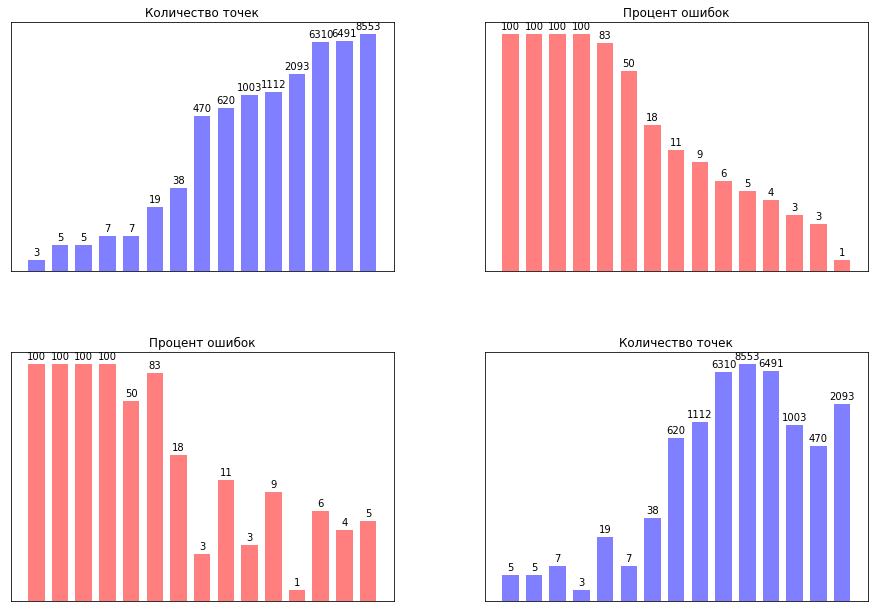

In [35]:
def paint_bars(axes, x, height, title, color, round_to=0, show_xaxes=False):
    """
    Строит bar на графике
    
    Parameters:
    axes, x, height            : Ось для нанесения bar с категориями x и высотой height
    title                      : Заголовок
    color                      : Цвет
    round_to                   : Округлить значения на анотациях bars
    show_xaxes                 : Показать подписи x-оси
    """
    
    rects = axes.bar(x = x, height = height, width = 0.7,
        align = 'center', alpha = 0.5, log=True, color=color)
    for tick in axes.get_xticklabels():
        tick.set_rotation(90)
    axes.set_title(title)
    for rect in rects:
        h = rect.get_height()
        axes.annotate(f'{int(round(h,round_to))}' if round_to==0 else f'{round(h,round_to):.{round_to}f}',
                    xy=(rect.get_x() + rect.get_width() / 2, h),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
    axes.get_xaxis().set_visible(show_xaxes)
    axes.get_yaxis().set_visible(False)

    return axes


fig, axes = plt.subplots(2,2,figsize=(14,10))
fig.tight_layout(pad=6.0)
df_aux = df_pred_result.iloc[:15].sort_values('test_samples_counts',ascending=True)
axes[0,0] = paint_bars(axes[0,0], df_aux.index.astype('str'), df_aux['test_samples_counts'],
                        'Количество точек', 'b')
axes[1,0] = paint_bars(axes[1,0], df_aux.index.astype('str'), df_aux['wrong_predicted_percentage'],
                        'Процент ошибок', 'r')
df_aux = df_pred_result.iloc[:15].sort_values('wrong_predicted_percentage',ascending=False)
axes[1,1] = paint_bars(axes[1,1], df_aux.index.astype('str'), df_aux['test_samples_counts'],
                        'Количество точек', 'b')
axes[0,1] = paint_bars(axes[0,1], df_aux.index.astype('str'), df_aux['wrong_predicted_percentage'],
                        'Процент ошибок', 'r')
plt.show()

Из проведенного эксперимента видно, что из 12 классов с количеством точек меньшим 100, есть 5 классов с относительной ошибкой больше 50 процентов. Согласовали с бизнесом, что по классам с количеством точек меньше 25 целевую переменную не предсказываем, но сообщаем пользователю список этих классов. Тем не менее, *в дальнейших экспериментах используем все классы*.

**Посмотрим, повысится ли точность, если исключить из данных классы с количеством точек меньшим 25.**

In [36]:
# Классы с количеством сэмплов больше 25 (samples_threshold=25)
model, y_pred, val_score, xval_scores, _ = \
    get_model(rfc, one_hot_encoder, drop_na=False, list_of_features=mic_selected_features,
              get_data_info=False, samples_threshold=25)

Model footprint:
 Selected Features
 <class 'sklearn.ensemble._forest.RandomForestClassifier'>
 <class 'sklearn.preprocessing._encoders.OneHotEncoder'>
 fill_na
 Big classes
 -----------------------------------------------------------------
Accuracy Score отложенной выборки: 0.992
Выполнено за 5.629 сек.
Средняя оценка при кросс-валидации: 0.977
Выполнено за 9.904 сек.




In [37]:
ms = pd.DataFrame(data=stat_data)
ms[-2:].loc[:,('feat_name','classes_name','val_score','xval_scores_mean','xval_scores')]

,feat_name,classes_name,val_score,xval_scores_mean,xval_scores
4,Selected Features,All classes,0.924885,0.925217,"[0.92466, 0.93909, 0.9119]"
5,Selected Features,Big classes,0.992346,0.976787,"[0.97792, 0.98584, 0.9666]"


Значительно повысилась. Неудивительно, ведь balanced accuracy score учитывает несбалансированность классов. Исключив классы с самой высокой относительной ошибкой предсказаний мы повысили точность. __Обратите внимание, мы продолжаем эксперименты с обучением на всех классах. Тем не менее классы с малым количеством сэмплов является ошибкой входных данных: с одного адреса доставки не может грузиться мало точек.__

### Эксперимент. Как отсутствие иерархий влияет на ошибки предсказания?

Обучим модель, заменив пропуски (*drop_na=False*) и определяя замененные значения, как факт отсутствия иерархии (напомним, что у нас имеется две иерархии: дистрибьюторов и сотрудников). Построим графики с типом bar для первых 15-ти классов с наибольшей относительной ошибкой (*do_pred_result=True возвращает посчитанную таблицу для анализа*).

In [38]:
model, y_pred, val_score, xval_scores, df_pred_result = \
    get_model(rfc, one_hot_encoder, drop_na=False, list_of_features=mic_selected_features,
              get_data_info=False, samples_threshold=2, do_pred_result=True)

Model footprint:
 Selected Features
 <class 'sklearn.ensemble._forest.RandomForestClassifier'>
 <class 'sklearn.preprocessing._encoders.OneHotEncoder'>
 fill_na
 All classes
 -----------------------------------------------------------------
Accuracy Score отложенной выборки: 0.925
Выполнено за 6.052 сек.
Средняя оценка при кросс-валидации: 0.925
Выполнено за 10.204 сек.




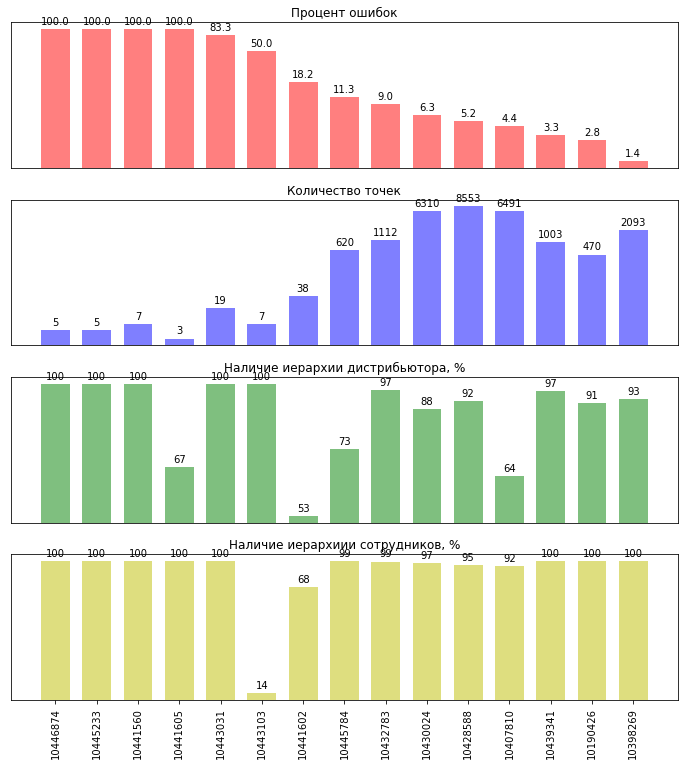

In [39]:
fig, axes = plt.subplots(4,1,figsize=(10,10))
fig.tight_layout()
df_aux = df_pred_result.iloc[:15].sort_values('wrong_predicted_percentage',ascending=False)

axes[0] = paint_bars(axes[0], df_aux.index.astype('str'), df_aux['wrong_predicted_percentage'],
                        'Процент ошибок', 'r', 1)
axes[1] = paint_bars(axes[1], df_aux.index.astype('str'), df_aux['test_samples_counts'],
                        'Количество точек', 'b', 0)
axes[2] = paint_bars(axes[2], df_aux.index.astype('str'), df_aux['dist_hierarchy_exists_percentage'],
                        'Наличие иерархии дистрибьютора, %', 'g',0)
axes[3] = paint_bars(axes[3], df_aux.index.astype('str'), df_aux['associates_hierarchy_exists_percentage'],
                        'Наличие иерархиии сотрудников, %', 'y', 0, show_xaxes=True)

Убеждаемся, что при снижении относительной ошибки на графиках отсутствуют явные патерны для иерархий дистрибьюторов и сотрудников. Делаем вывод, что **наличие/отсутствие иерархий не оказывает заметного влияния на ошибки**.

### Эксперимент. Исключение данных с пропущенными значениями

Поскольку пропущенные значения разных признаков имеют одинаковую специальную метку, в момент кодировки OneHotEncoder, это может отрицательно влиять на процесс обучения. Попробуем удалить данные с пропущенными значениями (*drop_na=True*), тем более, что их не больше 10% от общего количества.

In [40]:
# Удалить пропущенные значения
model, y_pred, val_score, xval_scores, df_pred_result = \
    get_model(rfc, one_hot_encoder, drop_na=True, list_of_features=mic_selected_features,
              get_data_info=False, samples_threshold=2, do_pred_result=True)

Model footprint:
 Selected Features
 <class 'sklearn.ensemble._forest.RandomForestClassifier'>
 <class 'sklearn.preprocessing._encoders.OneHotEncoder'>
 drop_na
 All classes
 -----------------------------------------------------------------
Accuracy Score отложенной выборки: 0.944
Выполнено за 4.582 сек.
Средняя оценка при кросс-валидации: 0.938
Выполнено за 8.875 сек.




Мы получили ещё больший score при валидации и кросс-валидации. Визуализируем

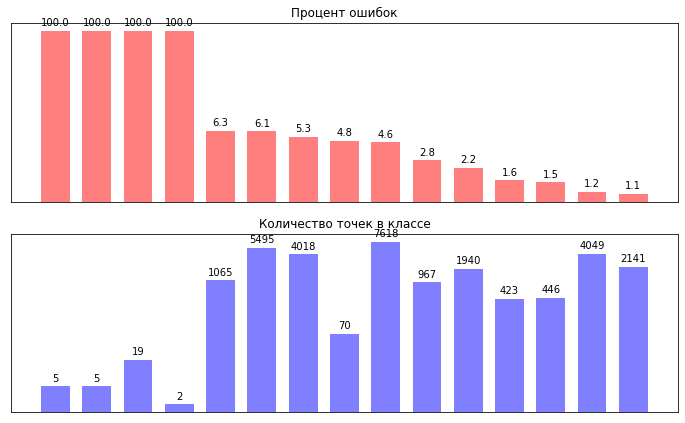

In [41]:
fig, axes = plt.subplots(2,1,figsize=(10,6))
fig.tight_layout()
df_aux = df_pred_result.iloc[:15].sort_values('wrong_predicted_percentage',ascending=False)

axes[0] = paint_bars(axes[0], df_aux.index.astype('str'), df_aux['wrong_predicted_percentage'],
                        'Процент ошибок', 'r', 1)
axes[1] = paint_bars(axes[1], df_aux.index.astype('str'), df_aux['test_samples_counts'],
                        'Количество точек в классе', 'b', 0)

В результате эксперимента принимаем подход с удалением строк с пропущенными значениями, т.к. на валидации повышается точность модели.

In [42]:
# Результаты последних 2-х экспериментов
ms = pd.DataFrame(data=stat_data)
ms[-2:].loc[:,('drop_na_name','feat_name','classes_name','val_score','xval_scores_mean','xval_scores')]

,drop_na_name,feat_name,classes_name,val_score,xval_scores_mean,xval_scores
6,fill_na,Selected Features,All classes,0.924885,0.925217,"[0.92466, 0.93909, 0.9119]"
7,drop_na,Selected Features,All classes,0.944260,0.937770,"[0.9333, 0.94752, 0.93249]"


### Эксперимент. Сравнение важности признаков из модели RandomForestClassifier с полученными из Mutual Information Classificator

Чтобы получать информацию о важности исходных признаков будем использовать OrdinalEncoder (OneHotEncoder создает много двоичных признаков которые сложно анализировать).

**Важность признаков из Mutual Information Classifier (MIC)**

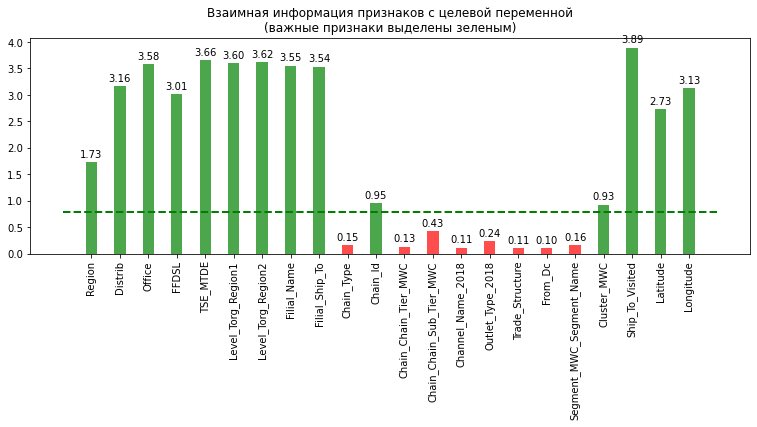

In [43]:
# mic_feature_importance хранит результаты важности признаков по версии MIC
mic_selected_features_20 = get_important_features(mic_feature_importance, 0.2)

In [44]:
# Зададим явный набор признаков list_of_features
model, y_pred, val_score, xval_scores, df_pred_result = \
    get_model(rfc, ordinal_encoder, drop_na=True, list_of_features=mic_selected_features_20,
              get_data_info=True, do_xval=True, samples_threshold=2, do_pred_result=False)

Model footprint:
 Selected Features
 <class 'sklearn.ensemble._forest.RandomForestClassifier'>
 <class 'category_encoders.ordinal.OrdinalEncoder'>
 drop_na
 All classes
 -----------------------------------------------------------------
Размер выборки total: 184762, train: 129333, valid: 55429
Количество признаков: 14 (Region, Distrib, Office, FFDSL, TSE_MTDE, Level_Torg_Region1, Level_Torg_Region2, Filial_Name, Filial_Ship_To, Chain_Id, Cluster_MWC, Ship_To_Visited, Latitude, Longitude)
Accuracy Score отложенной выборки: 0.941
Выполнено за 2.013 сек.
Средняя оценка при кросс-валидации: 0.936
Выполнено за 4.699 сек.




**Важность признаков из классификатора RandomForestClassifier**

Обучим модель на всех признаках и получим важность признаков из классификатора

In [45]:
# Зададим явный набор признаков (все признаки)
all_features = [item for item in list(df.columns.values) if item not in ['SHIP_TO_RSS','isCoord','isTrain']]
model, y_pred, val_score, xval_scores, df_pred_result = \
    get_model(rfc, ordinal_encoder, drop_na=True, list_of_features=all_features,
              get_data_info=True, do_xval=True, samples_threshold=2, do_pred_result=False)

Model footprint:
 Selected Features
 <class 'sklearn.ensemble._forest.RandomForestClassifier'>
 <class 'category_encoders.ordinal.OrdinalEncoder'>
 drop_na
 All classes
 -----------------------------------------------------------------
Размер выборки total: 184762, train: 129333, valid: 55429
Количество признаков: 22 (Region, Distrib, Office, FFDSL, TSE_MTDE, Level_Torg_Region1, Level_Torg_Region2, Filial_Name, Filial_Ship_To, Chain_Type, Chain_Id, Chain_Chain_Tier_MWC, Chain_Chain_Sub_Tier_MWC, Channel_Name_2018, Outlet_Type_2018, Trade_Structure, From_Dc, Segment_MWC_Segment_Name, Cluster_MWC, Ship_To_Visited, Latitude, Longitude)
Accuracy Score отложенной выборки: 0.944
Выполнено за 2.355 сек.
Средняя оценка при кросс-валидации: 0.940
Выполнено за 5.874 сек.




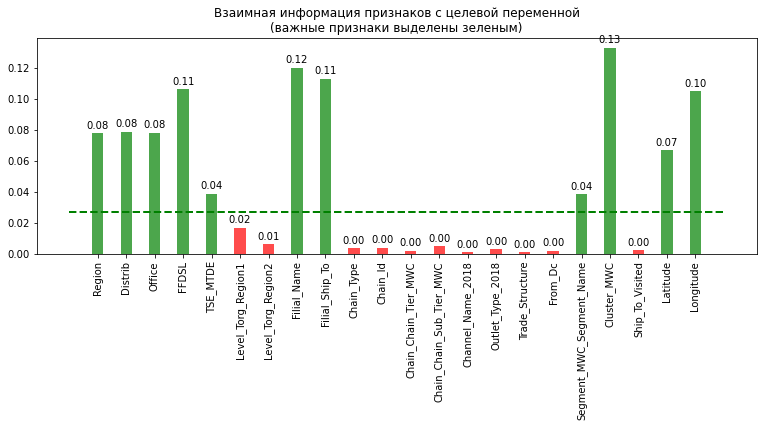

Важные признаки полученные из классификатора: Region, Distrib, Office, FFDSL, TSE_MTDE, Filial_Name, Filial_Ship_To, Segment_MWC_Segment_Name, Cluster_MWC, Latitude, Longitude


In [46]:
# Получить объект с классификатором
rfc = model.named_steps['classifier']
# Создадим словарь Признаки-Важность
rfc_feature_importance = {'features':all_features, 'importance':rfc.feature_importances_}
# Визуализируем
rfc_selected_features_20 = get_important_features(rfc_feature_importance, 0.2)
print(f"Важные признаки полученные из классификатора: {', '.join(rfc_selected_features_20)}")

Интересно отметить, что классификатор занизил важность признаков Ship_To_Visited, Level_Torg_Region1, Level_Torg_region2. Отбросим признаки с низкой важностью и обучим модель на отобранных признаках.

In [47]:
# Обучим на отобранных признаках
model, y_pred, val_score, xval_scores, df_pred_result = \
    get_model(rfc, ordinal_encoder, drop_na=True, list_of_features=rfc_selected_features_20,
              get_data_info=True, do_xval=True, samples_threshold=2, do_pred_result=False)

Model footprint:
 Selected Features
 <class 'sklearn.ensemble._forest.RandomForestClassifier'>
 <class 'category_encoders.ordinal.OrdinalEncoder'>
 drop_na
 All classes
 -----------------------------------------------------------------
Размер выборки total: 184762, train: 129333, valid: 55429
Количество признаков: 11 (Region, Distrib, Office, FFDSL, TSE_MTDE, Filial_Name, Filial_Ship_To, Segment_MWC_Segment_Name, Cluster_MWC, Latitude, Longitude)
Accuracy Score отложенной выборки: 0.924
Выполнено за 1.407 сек.
Средняя оценка при кросс-валидации: 0.914
Выполнено за 3.867 сек.




Точность модели ухудшилась. Попробуем взять все признаки с относительным вкладом выше 10%

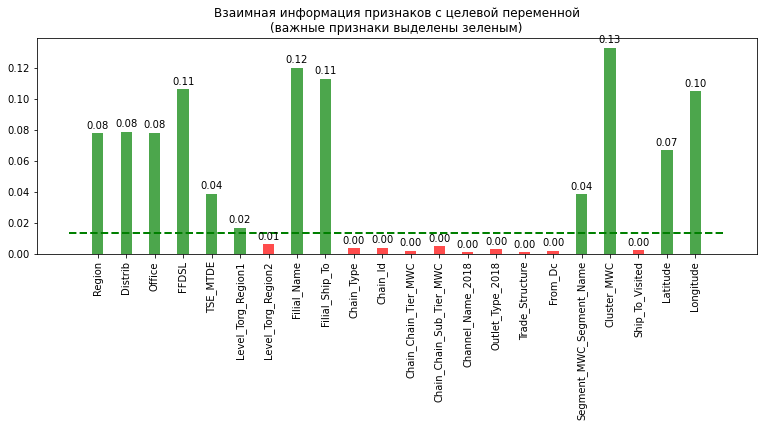

Важные признаки полученные из классификатора: Region, Distrib, Office, FFDSL, TSE_MTDE, Level_Torg_Region1, Filial_Name, Filial_Ship_To, Segment_MWC_Segment_Name, Cluster_MWC, Latitude, Longitude


In [48]:
rfc_selected_features_10 = get_important_features(rfc_feature_importance, 0.1)
print(f"Важные признаки полученные из классификатора: {', '.join(rfc_selected_features_10)}")

In [49]:
# Зададим явный набор признаков
model, y_pred, val_score, xval_scores, df_pred_result = \
    get_model(rfc, ordinal_encoder, drop_na=True, list_of_features=rfc_selected_features_10,
              get_data_info=True, do_xval=True, samples_threshold=2, do_pred_result=False)

Model footprint:
 Selected Features
 <class 'sklearn.ensemble._forest.RandomForestClassifier'>
 <class 'category_encoders.ordinal.OrdinalEncoder'>
 drop_na
 All classes
 -----------------------------------------------------------------
Размер выборки total: 184762, train: 129333, valid: 55429
Количество признаков: 12 (Region, Distrib, Office, FFDSL, TSE_MTDE, Level_Torg_Region1, Filial_Name, Filial_Ship_To, Segment_MWC_Segment_Name, Cluster_MWC, Latitude, Longitude)
Accuracy Score отложенной выборки: 0.925
Выполнено за 1.482 сек.
Средняя оценка при кросс-валидации: 0.912
Выполнено за 3.930 сек.




Проведенный эксперимент показал, что признаки Ship_To_Visited, Level_Torg_Region1, Level_Torg_region2 важны для модели и поэтому их убирать нельзя.

### Эксперимент. Оценка важности признаков в кодировке OneHotEncoder

Обучим модель с полным набором признаков в кодировке OneHotEncoder и визуализируем их важность. Данные будем получать из объекта Pipeline специальным приемом.

In [50]:
# Полный набор признаков
model, y_pred, val_score, xval_scores, df_pred_result = \
    get_model(rfc, one_hot_encoder, drop_na=True, list_of_features=all_features,
              get_data_info=True, do_xval=True, samples_threshold=2, do_pred_result=False)

Model footprint:
 Selected Features
 <class 'sklearn.ensemble._forest.RandomForestClassifier'>
 <class 'sklearn.preprocessing._encoders.OneHotEncoder'>
 drop_na
 All classes
 -----------------------------------------------------------------
Размер выборки total: 184762, train: 129333, valid: 55429
Количество признаков: 22 (Region, Distrib, Office, FFDSL, TSE_MTDE, Level_Torg_Region1, Level_Torg_Region2, Filial_Name, Filial_Ship_To, Chain_Type, Chain_Id, Chain_Chain_Tier_MWC, Chain_Chain_Sub_Tier_MWC, Channel_Name_2018, Outlet_Type_2018, Trade_Structure, From_Dc, Segment_MWC_Segment_Name, Cluster_MWC, Ship_To_Visited, Latitude, Longitude)
Accuracy Score отложенной выборки: 0.948
Выполнено за 4.510 сек.
Средняя оценка при кросс-валидации: 0.941
Выполнено за 9.528 сек.




In [51]:
# Разделим признаки на категорийные и числовые (также как это делали в самом Pipeline)
cat_features = df[all_features].select_dtypes(include=['object']).columns  # Categorical
num_features = df[all_features].select_dtypes(exclude=['object']).columns  # Numeric

# Получить объект OneHotEncoder
ohe = (model.named_steps['preprocess']
       .named_transformers_['cat']
       .named_steps['encoder'])

# Получить названия новых One Hot признаков
cat_ohe_feature_names = ohe.get_feature_names(input_features=cat_features)

# К One Hot признакам присоединить числовые признаки, которые участвовали в обучении модели
feature_names = np.append(cat_ohe_feature_names, num_features)

# Вместо уникальных названий One Hot признаков получить массив исходных названий признаков той же длины
features_raw = []
for fname, fval  in zip(cat_features,ohe.categories_):
    features_raw = np.append(features_raw, [fname] * len(fval))
features_raw = np.append(features_raw, num_features)

# Получить объект с классификатором из которого получим значения важности One Hot признаков
rfc = model.named_steps['classifier']

# Создадим набор данных с тремя столбцами:
# исходный признак, соответствующий ему One Hot признак, значение важности признака из классификатора
df_imp = pd.DataFrame(
        {"Feature":features_raw,
         "FeatureName":feature_names,
         "Importance":rfc.feature_importances_}
    ).sort_values(["Importance"], ascending=False)

Визуализируем признаки на графике с boxplot, где числовые признаки будут показаны одним значением, в то время как категорийные признаки будут показаны в виде box & whiskers на которых можно оценить статистику распределения признака.

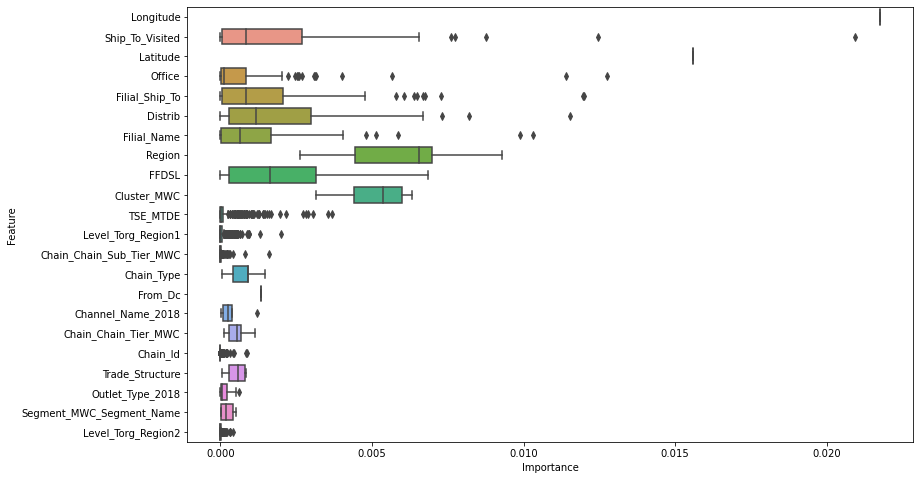

In [52]:
import seaborn as sns
fig, axes = plt.subplots(figsize=(13, 8))
sns.boxplot(data=df_imp, 
            y="Feature", 
            x="Importance", 
           )

Если принять медианное значение важности признака как опорное, то признаки выстраиваются в следующем порядке.

In [53]:
feature_importance_list = list(df_imp.groupby('Feature').Importance.median().sort_values(ascending=False).index)
print(f"Список признаков в порядке убывания важности:\n{', '.join(feature_importance_list)}")

Список признаков в порядке убывания важности:
Longitude, Latitude, Region, Cluster_MWC, FFDSL, From_Dc, Distrib, Chain_Type, Filial_Ship_To, Ship_To_Visited, Filial_Name, Trade_Structure, Chain_Chain_Tier_MWC, Channel_Name_2018, Segment_MWC_Segment_Name, Office, Outlet_Type_2018, TSE_MTDE, Level_Torg_Region1, Chain_Chain_Sub_Tier_MWC, Level_Torg_Region2, Chain_Id


### Эксперимент с исключением One-Hot признаков, с низкой важностью

In [54]:
# Получим наборы данных со всеми признаками
X, y, X_train, X_valid, y_train, y_valid = \
    get_data(drop_na=True, list_of_features=None,
             samples_threshold=2, get_data_info=True)

Размер выборки total: 184762, train: 129333, valid: 55429
Количество признаков: 22 (Region, Distrib, Office, FFDSL, TSE_MTDE, Level_Torg_Region1, Level_Torg_Region2, Filial_Name, Filial_Ship_To, Chain_Type, Chain_Id, Chain_Chain_Tier_MWC, Chain_Chain_Sub_Tier_MWC, Channel_Name_2018, Outlet_Type_2018, Trade_Structure, From_Dc, Segment_MWC_Segment_Name, Cluster_MWC, Ship_To_Visited, Latitude, Longitude)


In [55]:
# Удалить столбцы по индексам
def dropcols_coo(M, idx_to_drop):
    """ Удаляет столбцы по индексам в разряженной матрице csr
    
    """
    idx_to_drop = np.unique(idx_to_drop)
    C = M.tocoo()
    keep = ~np.in1d(C.col, idx_to_drop)
    C.data, C.row, C.col = C.data[keep], C.row[keep], C.col[keep]
    C.col -= idx_to_drop.searchsorted(C.col)    # decrement column indices
    C._shape = (C.shape[0], C.shape[1] - len(idx_to_drop))

    return C.tocsr()


def get_reduced_one_hot_matrix(X, non_important_features):
    """
    Получает набор данных X, затем преобразует его категорийные признаки в One Hot Encoding, затем
    удаляет столбцы названия которых соответствует названиям элементов из списка non_important_features,
    к получившейся sparse matrix добавляет числовые признаки и возвращает финальный результат
    
    """
    
    # Разделим признаки на категорийные и числовые
    cat_features = X.select_dtypes(include=['object']).columns  # Categorical
    num_features = X.select_dtypes(exclude=['object']).columns  # Numeric
    
    # Трансформация категорийных признаков
    X_cat = X[cat_features]
    ohe = OneHotEncoder(handle_unknown='ignore')
    X_enc = ohe.fit_transform(X_cat)
    
    # Список признаков из обученного ohe
    ohe_feature_names = ohe.get_feature_names(input_features=cat_features)
    
    # Получить индексы не важных признаков в списке One Hot признаков обученного ohe 
    indexes_of_non_imp_features = []
    for i, name in enumerate(ohe_feature_names):
        if name in non_important_features:
            indexes_of_non_imp_features.append(i)
    
    X_reduced = X_enc.copy()
    if len(indexes_of_non_imp_features) > 0:
        # получен список индексов признаков, которые нужно удалить
        X_reduced = dropcols_coo(X_enc, indexes_of_non_imp_features)
    
    # Добавим числовые признаки
    X_reduced = scipy.sparse.hstack([X_reduced, X[num_features]])

    return X_reduced

In [56]:
# Всего признаков
total_features = len(df_imp.FeatureName.values)
# Список пороговых значений важности для отсечения признаков с низкой важностью
thresholds = [5e-03, 5e-06, 5e-09, 5e-12, 5e-15]
scores_list = []
number_features_list = []

# Выполним несколько экспериментов с разным количеством признаков. Результаты сохраним в списки
for threshold in thresholds:
    
    # Список не важных признаков
    df_imp_reduced = df_imp[df_imp['Importance']<threshold]
    features_to_exclude = df_imp_reduced.FeatureName.values
    
    # Количество признаков для обучения
    number_features = total_features - len(features_to_exclude)
    print(f"Порог: {threshold}, количество важных признаков: {number_features}")
    
    # Получить sparse matrix только с нужными признаками
    X_reduced = get_reduced_one_hot_matrix(X, features_to_exclude)
    scores = cross_val_score(rfc, X_reduced, y, cv=3, scoring='balanced_accuracy')
    print(f"Средняя оценка при кросс-валидации: {scores.mean():.4f}")
    
    scores_list.append(scores.mean())
    number_features_list.append(number_features)

Порог: 0.005, количество важных признаков: 44
Средняя оценка при кросс-валидации: 0.8466
Порог: 5e-06, количество важных признаков: 1523
Средняя оценка при кросс-валидации: 0.9422
Порог: 5e-09, количество важных признаков: 3355
Средняя оценка при кросс-валидации: 0.9429
Порог: 5e-12, количество важных признаков: 4065
Средняя оценка при кросс-валидации: 0.9399
Порог: 5e-15, количество важных признаков: 4092
Средняя оценка при кросс-валидации: 0.9390


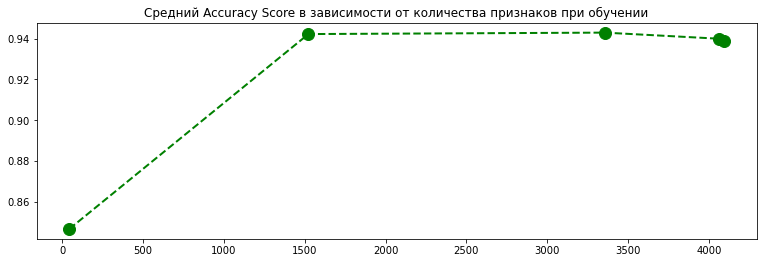

In [57]:
# Визуализируем
fig = plt.figure(figsize=(10,3))
axes = fig.add_axes([0, 0, 1, 1])
axes.plot(number_features_list, scores_list, color='green', marker='o', linestyle='dashed',
    linewidth=2, markersize=12)
axes.set_title(f'Средний Accuracy Score в зависимости от количества признаков при обучении')
plt.show()

Из результатов эксперимента видно, что можно преобразовать признаки в OneHotEncoding и оставить всего 44 самых важных, при этом точность всё равно останется хорошей. При увеличении количества признаков точность возрастает, достигая максимума на 3343 признаках, а затем начинает убывать. Это можно объяснить тем, что вначале большинство признаков несет больше информации, а затем признаки начинают приность больше шума. Поэтому точность начинается снижаться.

## Эксперимент. Подбор параметров моделей с помощью GridSearchCV

Для нескольких классификаторов методом перебора всех сочетаний параметров выполним поиск лучших параметров которые принесут наибольшую balanced_accuracy на кросс валидации cv=3

In [58]:
def grid_search_cv(classif_name, file_name, classifier, encoder, parameters):
    print(f"Поиск grid search лучших параметров для {classif_name}")

    file_name = file_name
    if os.path.isfile(file_name):
        print('Поиск уже выполнен. Эстиматор загружен с диска')
        best_estimator = pickle.load(open(file_name, 'rb'))
    else: 
        # Получим наборы данных со всеми признаками
        X, y, _, _, _, _ = \
            get_data(drop_na=True, list_of_features=None, samples_threshold=2, get_data_info=False)

        # Вернем модель не выполняя обучение
        model, _, _, _, _ = get_model(classifier, encoder, do_val=False, do_xval=False)

        grid_search = GridSearchCV(model, parameters, scoring='balanced_accuracy', cv=3, n_jobs=-1, verbose=10)

        print("Начало поиска лучших параметров...")
        print("pipeline:", [name for name, _ in model.steps])
        print("parameters:")
        pprint(parameters)
        t0 = time()
        grid_search.fit(X, y)
        print("Выполнено за %0.3f сек." % (time() - t0))
        print("Лучший score: %0.3f" % grid_search.best_score_)
        print()

        best_estimator = grid_search.best_estimator_
        pickle.dump(best_estimator, open(file_name, 'wb'))

    print("Лучший набор параметров:")
    best_parameters = best_estimator.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
        
    return best_estimator

#### RandomForestClassifier

In [59]:
parameters = {
    'classifier__n_estimators'            : [10, 100, 200, 300],
    'classifier__criterion'               : ['gini', 'entropy'],
    'classifier__max_depth'               : [None, 5, 10],
    'classifier__min_samples_split'       : [2, 3],
    'classifier__min_samples_leaf'        : [1, 2],
    'classifier__max_samples'             : [0.8, 0.1],
}
rfc = RandomForestClassifier(random_state=42, n_jobs=-1)
best_rfc = grid_search_cv('RandomForestClassifier', 'cv_best_rfc_estimator.pkl', rfc, one_hot_encoder, parameters)

Поиск grid search лучших параметров для RandomForestClassifier
Поиск уже выполнен. Эстиматор загружен с диска
Лучший набор параметров:
	classifier__criterion: 'entropy'
	classifier__max_depth: None
	classifier__max_samples: 0.8
	classifier__min_samples_leaf: 1
	classifier__min_samples_split: 2
	classifier__n_estimators: 200


In [87]:
# Проверим параметры
rfc, _, _, _, _ = \
    get_model(best_rfc, ordinal_encoder, drop_na=True, list_of_features=None,
              get_data_info=True, do_xval=False, samples_threshold=2, do_pred_result=False)

Model footprint:
 All features
 <class 'sklearn.pipeline.Pipeline'>
 <class 'category_encoders.ordinal.OrdinalEncoder'>
 drop_na
 All classes
 -----------------------------------------------------------------
Размер выборки total: 184762, train: 129333, valid: 55429
Количество признаков: 22 (Region, Distrib, Office, FFDSL, TSE_MTDE, Level_Torg_Region1, Level_Torg_Region2, Filial_Name, Filial_Ship_To, Chain_Type, Chain_Id, Chain_Chain_Tier_MWC, Chain_Chain_Sub_Tier_MWC, Channel_Name_2018, Outlet_Type_2018, Trade_Structure, From_Dc, Segment_MWC_Segment_Name, Cluster_MWC, Ship_To_Visited, Latitude, Longitude)
Accuracy Score отложенной выборки: 0.948
Выполнено за 56.659 сек.




#### LogisticRegression

In [60]:
# Проверка с OrdinalEncoder дает крайне низкий результат, поэтому экспериментируем с OneHotEncoder
parameters = {
    'classifier__max_iter'      : [10, 500, 1000, 1500],
    'classifier__class_weight'  : [None, 'balanced'],
    'classifier__C'             : [0.9, 1.0, 1.1],
}

lr = LogisticRegression(multi_class='ovr',random_state=42,n_jobs=-1)
best_lr = grid_search_cv('LogisticRegression', 'cv_best_lr_estimator.pkl', lr, one_hot_encoder, parameters)

Поиск grid search лучших параметров для LogisticRegression
Поиск уже выполнен. Эстиматор загружен с диска
Лучший набор параметров:
	classifier__C: 1.0
	classifier__class_weight: 'balanced'
	classifier__max_iter: 500


In [91]:
# Проверим параметры
lr, _, _, _, _ = \
    get_model(best_lr, ordinal_encoder, drop_na=True, list_of_features=None,
              get_data_info=True, do_xval=False, samples_threshold=2, do_pred_result=False)

Model footprint:
 All features
 <class 'sklearn.pipeline.Pipeline'>
 <class 'category_encoders.ordinal.OrdinalEncoder'>
 drop_na
 All classes
 -----------------------------------------------------------------
Размер выборки total: 184762, train: 129333, valid: 55429
Количество признаков: 22 (Region, Distrib, Office, FFDSL, TSE_MTDE, Level_Torg_Region1, Level_Torg_Region2, Filial_Name, Filial_Ship_To, Chain_Type, Chain_Id, Chain_Chain_Tier_MWC, Chain_Chain_Sub_Tier_MWC, Channel_Name_2018, Outlet_Type_2018, Trade_Structure, From_Dc, Segment_MWC_Segment_Name, Cluster_MWC, Ship_To_Visited, Latitude, Longitude)
Accuracy Score отложенной выборки: 0.957
Выполнено за 193.297 сек.




#### KNeighborsClassifier

In [83]:
parameters = {
    'classifier__n_neighbors'             : [3, 5, 7],
    'classifier__weights'                 : ['uniform', 'distance'],
    'classifier__algorithm'               : ['ball_tree', 'kd_tree'],
    'classifier__leaf_size'               : [25, 30],
}
knc = KNeighborsClassifier(metric='minkowski', metric_params=None, n_jobs=-1, p=2)
best_knc = grid_search_cv('KNeighborsClassifier', 'cv_best_knc_estimator.pkl', knc, ordinal_encoder, parameters)

Поиск grid search лучших параметров для KNeighborsClassifier
Поиск уже выполнен. Эстиматор загружен с диска
Лучший набор параметров:
	classifier__algorithm: 'ball_tree'
	classifier__leaf_size: 25
	classifier__n_neighbors: 5
	classifier__weights: 'distance'


In [93]:
# Проверим параметры
knc, _, _, _, _ = \
    get_model(best_knc, ordinal_encoder, drop_na=True, list_of_features=None,
              get_data_info=True, do_xval=False, samples_threshold=2, do_pred_result=False)

Model footprint:
 All features
 <class 'sklearn.pipeline.Pipeline'>
 <class 'category_encoders.ordinal.OrdinalEncoder'>
 drop_na
 All classes
 -----------------------------------------------------------------
Размер выборки total: 184762, train: 129333, valid: 55429
Количество признаков: 22 (Region, Distrib, Office, FFDSL, TSE_MTDE, Level_Torg_Region1, Level_Torg_Region2, Filial_Name, Filial_Ship_To, Chain_Type, Chain_Id, Chain_Chain_Tier_MWC, Chain_Chain_Sub_Tier_MWC, Channel_Name_2018, Outlet_Type_2018, Trade_Structure, From_Dc, Segment_MWC_Segment_Name, Cluster_MWC, Ship_To_Visited, Latitude, Longitude)
Accuracy Score отложенной выборки: 0.934
Выполнено за 40.260 сек.




Убеждаемся, что способ перебора сочетаний параметров работает, хотя и занимает продолжительное время. Найдены параметры для классификации логистической регрессии с лучшей сбалансированной точностью!

### Эксперимент. Stacking Classifier
Stacking Classifer использует выходы нескольких базовых эстиматоров для обучения мета-классификатора. Это позволяет использовать преимущества каждого из базовых эстиматоров. Обычно, стакинг дает лучший скор и используется в соревнованиях как финальный аргумент. В качестве Stacking Classifer будем использовать классификатор из модуля mlxtend http://rasbt.github.io/mlxtend/user_guide/classifier/StackingClassifier/#stackingclassifier

Выполнять стакинг будем без обучения базовых эстиматоров (они обучены ранее) и используя значения вероятностей классов базовых эстиматоров (use_probas=True, average_probas=False). Мета-классификатор - LogisticRegression.

In [109]:
from mlxtend.classifier import StackingClassifier

file_name = 'stacking_classifier.pkl'
# Получим наборы данных со всеми признаками
_, _, X_train, X_valid, y_train, y_valid = \
    get_data(drop_na=True, list_of_features=None, samples_threshold=2, get_data_info=True)

stacking_classifier = StackingClassifier(classifiers=[rfc, lr, knc], 
                                         use_probas=True,
                                         average_probas=False,
                                         meta_classifier=LogisticRegression(class_weight='balanced',
                                                                            max_iter=100,
                                                                            multi_class='ovr',
                                                                            n_jobs=-1, random_state=42),
                                         fit_base_estimators=False)

if os.path.isfile(file_name):
    print('Загружен с диска')
    stacking_classifier = pickle.load(open(file_name, 'rb'))
else:
    print("Начало обучения")
    t0 = time()
    stacking_classifier.fit(X_train, y_train)
    t1 = time() - t0
    pickle.dump(stacking_classifier, open('stacking_classifier.pkl', 'wb'))
    print("Выполнено за %0.3f сек." % (t1))

y_pred = stacking_classifier.predict(X_valid)
val_score = balanced_accuracy_score(y_valid, y_pred)
print(f"Accuracy Score отложенной выборки: {val_score:.3f}")
print("Выполнено за %0.3f сек." % (t1))

Размер выборки total: 184762, train: 129333, valid: 55429
Количество признаков: 22 (Region, Distrib, Office, FFDSL, TSE_MTDE, Level_Torg_Region1, Level_Torg_Region2, Filial_Name, Filial_Ship_To, Chain_Type, Chain_Id, Chain_Chain_Tier_MWC, Chain_Chain_Sub_Tier_MWC, Channel_Name_2018, Outlet_Type_2018, Trade_Structure, From_Dc, Segment_MWC_Segment_Name, Cluster_MWC, Ship_To_Visited, Latitude, Longitude)
Загружен с диска
Accuracy Score отложенной выборки: 0.960
Выполнено за 801.571 сек.


Стакинг скор оказался выше скора каждого отдельного классификатора. Мы получили чемпионскую точность!

### XGBoost классификатор
https://xgboost.readthedocs.io/en/latest/

In [237]:
import xgboost as xgb

def xgboost_model(encoder='ordinal'):
    """
    Получает набор данных в кодировке OrdinalEncoder или OneHotEncoder,
    обучает и валидирует XGBoost классификатор
    
    Parameters:
    encoder (str)       : 'ordinal' - использовать кодировку OrdinalEncoder, иначе - OneHotEncoder
    """
    
    if encoder == 'ordinal':
        ordinal = True
        encoder = "<class 'category_encoders.ordinal.OrdinalEncoder'>"
    else:
        ordinal = False
        encoder = "<class 'sklearn.preprocessing._encoders.OneHotEncoder'>"
        
    all_features = [item for item in list(df.columns.values) if item not in ['SHIP_TO_RSS','isCoord','isTrain']]
    # Получим наборы данных со всеми признаками, с выполненным кодированием (do_encode=True)
    X, y, X_train, X_valid, y_train, y_valid = \
        get_data(drop_na=True, list_of_features=all_features, samples_threshold=2, get_data_info=True,
                 do_encode=True, ordinal=ordinal)

    # Данные кодированны (!)
    xg_train = xgb.DMatrix(data = X_train, label=y_train,
                           feature_names=all_features if ordinal else None)
    xg_valid = xgb.DMatrix(data = X_valid, label=y_valid,
                           feature_names=all_features if ordinal else None)

    param = {}
    param['objective'] = 'multi:softmax'      # используем multi-class классификацию
    param['eta'] = 0.2                        # learning rate
    param['max_depth'] = 50
    param['subsample'] = 0.5                  # размер случайного сэмпла данных (борьба с переобучением)
    param['nthread'] = 8
    param['num_class'] = len(np.unique(y))
    param['eval_metric'] = 'mlogloss'

    evallist = [(xg_train, 'train'), (xg_valid, 'valid')]
    epochs = 100
    store = {}

    t0 = time()
    bst = xgb.train(param, xg_train, epochs, evallist, evals_result=store, early_stopping_rounds=5)
    t1 = time() - t0
    # get prediction
    y_pred = bst.predict(xg_valid)
    val_score = balanced_accuracy_score(y_valid, y_pred)
    print(f"Accuracy Score отложенной выборки: {val_score:.3f}")
    print("Выполнено за %0.3f сек." % (t1))
    
    # Результаты модели добавить в статистики
    model_dict = {'model_name':'xgboost',
                  'feat_name':'All features',
                  'drop_na_name':'drop_na',
                  'classes_name':'All classes',
                  'val_score':val_score, 't1':t1,
                  'samples_threshold':2, 'features':all_features,
                  'encoder':encoder,
                  'classifier':'xgboost',
                  'epochs':epochs}
    stat_data.append(model_dict)
    
    return bst, store

In [233]:
# Классификатор XGBoost, способ кодировки OrdinalEncoder
bst, store = xgboost_model('ordinal')

Размер выборки total: 184762, train: 129333, valid: 55429
Количество признаков: 22 (Region, Distrib, Office, FFDSL, TSE_MTDE, Level_Torg_Region1, Level_Torg_Region2, Filial_Name, Filial_Ship_To, Chain_Type, Chain_Id, Chain_Chain_Tier_MWC, Chain_Chain_Sub_Tier_MWC, Channel_Name_2018, Outlet_Type_2018, Trade_Structure, From_Dc, Segment_MWC_Segment_Name, Cluster_MWC, Ship_To_Visited, Latitude, Longitude)
[0]	train-mlogloss:0.149504	valid-mlogloss:0.150066
Multiple eval metrics have been passed: 'valid-mlogloss' will be used for early stopping.

Will train until valid-mlogloss hasn't improved in 5 rounds.
[1]	train-mlogloss:0.1107	valid-mlogloss:0.112517
[2]	train-mlogloss:0.091423	valid-mlogloss:0.094734
[3]	train-mlogloss:0.07749	valid-mlogloss:0.082284
[4]	train-mlogloss:0.066588	valid-mlogloss:0.072308
[5]	train-mlogloss:0.057531	valid-mlogloss:0.06437
[6]	train-mlogloss:0.050304	valid-mlogloss:0.058205
[7]	train-mlogloss:0.044204	valid-mlogloss:0.052877
[8]	train-mlogloss:0.039103	val

Визуализируем важность признаков и зависимость метрики mlogloss от количества эпох. Для визуализации важности признаков используем возможности самого XGBoost

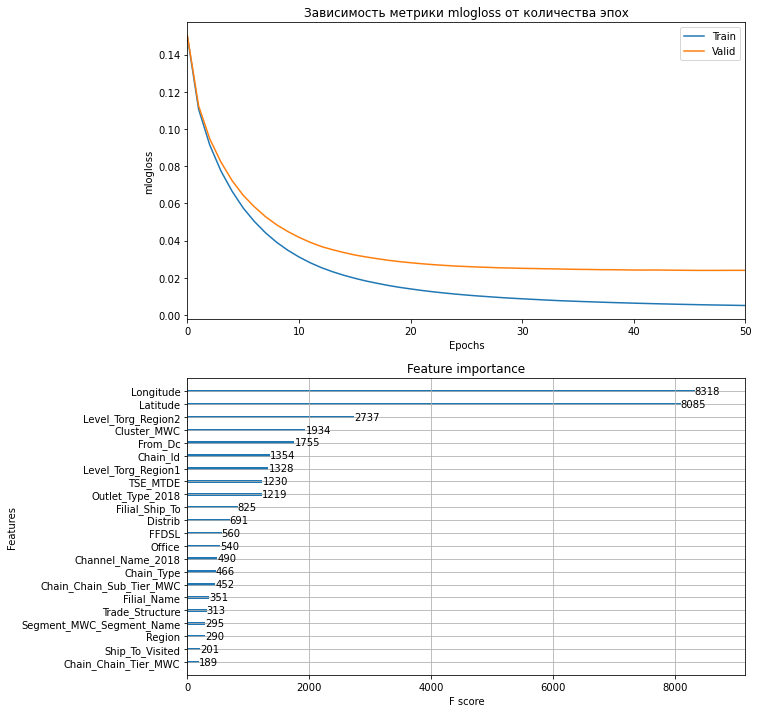

In [230]:
score_train = store['train']['mlogloss']
score_valid = store['valid']['mlogloss']

fig, axes = plt.subplots(2, 1, figsize=(10,12))
# Metrics
pd.DataFrame(data={'Train':score_train, 'Valid':score_valid}) \
    .plot(ax = axes[0], title='Зависимость метрики mlogloss от количества эпох')
axes[0].set_xticklabels((np.arange(bst.best_iteration) * 10).astype(str))
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('mlogloss')
# Feature importance
xgb.plot_importance(bst, ax=axes[1])
plt.show()

На XGBoost мы получили точность похожую на другие классификаторы. Этот алгоритм на первое по важности поставил не только признаки: Longitude, Latitude, но также Level_Torg_Region2, Cluster_MWC, From_Dc, Chain_Id, которые в предыдущих экспериментах не демонстрировали выдающуюся важность.

Проведем обучение с теми же параметрами, но используем OneHotEncoder

In [238]:
# Классификатор XGBoost, способ кодировки OneHotEncoder
bst, store = xgboost_model('one_hot')

Размер выборки total: 184762, train: 129333, valid: 55429
Количество признаков: 22 (Region, Distrib, Office, FFDSL, TSE_MTDE, Level_Torg_Region1, Level_Torg_Region2, Filial_Name, Filial_Ship_To, Chain_Type, Chain_Id, Chain_Chain_Tier_MWC, Chain_Chain_Sub_Tier_MWC, Channel_Name_2018, Outlet_Type_2018, Trade_Structure, From_Dc, Segment_MWC_Segment_Name, Cluster_MWC, Ship_To_Visited, Latitude, Longitude)
[0]	train-mlogloss:0.114543	valid-mlogloss:0.114794
Multiple eval metrics have been passed: 'valid-mlogloss' will be used for early stopping.

Will train until valid-mlogloss hasn't improved in 5 rounds.
[1]	train-mlogloss:0.082755	valid-mlogloss:0.083415
[2]	train-mlogloss:0.068778	valid-mlogloss:0.070733
[3]	train-mlogloss:0.058651	valid-mlogloss:0.061607
[4]	train-mlogloss:0.050913	valid-mlogloss:0.054663
[5]	train-mlogloss:0.044557	valid-mlogloss:0.049257
[6]	train-mlogloss:0.039445	valid-mlogloss:0.044839
[7]	train-mlogloss:0.035091	valid-mlogloss:0.041185
[8]	train-mlogloss:0.031429

In [239]:
ms = pd.DataFrame(data=stat_data)
ms[-2:].loc[:,('model_name','val_score','encoder')]

,model_name,val_score,encoder
17,xgboost,0.931435,<class 'category_encoders.ordinal.OrdinalEncod...
18,xgboost,0.935871,<class 'sklearn.preprocessing._encoders.OneHot...


XGBoost показал результаты сравнимые с алгоритмом RandomForestClassifier, при этом требует больше времени для обучения. Кодировка в стиле OneHotEncoder дает лучшие результаты.

### CatBoost классификатор
https://catboost.ai/docs/concepts/python-reference_catboostclassifier.html

In [ ]:
def catboost_model(encoder='ordinal'):
    
    if encoder == 'ordinal':
        ordinal = True
        encoder = "<class 'category_encoders.ordinal.OrdinalEncoder'>"
    else:
        ordinal = False
        encoder = "<class 'sklearn.preprocessing._encoders.OneHotEncoder'>"
       
    # Получим наборы данных со всеми признаками, с выполненным кодированием (do_encode=True)
    _, _, X_train, X_valid, y_train, y_valid = \
        get_data(drop_na=True, list_of_features=None, samples_threshold=2, get_data_info=True,
                 do_encode=True, ordinal=ordinal)

    X_train_set = Pool(data=X_train,
                       label=y_train)
    X_valid_set = Pool(data=X_valid,
                       label=y_valid)

    iterations = 200
    # Инициализировать CatBoostClassifier
    model = CatBoostClassifier(iterations=200,
                               learning_rate=0.26,
                               depth=6,
                               loss_function='MultiClass',
                               early_stopping_rounds=5)
    t0 = time()
    # Обучить модель
    model.fit(X_train_set)
    t1 = time() - t0
    # Получить предсказания
    y_pred = model.predict(X_valid_set)

    val_score = balanced_accuracy_score(y_valid, y_pred)
    print(f"Accuracy Score отложенной выборки: {val_score:.3f}")
    print("Выполнено за %0.3f сек." % (t1))

    # Результаты модели добавить в статистики
    model_dict = {'model_name':'xgboost',
                  'feat_name':'All features',
                  'drop_na_name':'drop_na',
                  'classes_name':'All classes',
                  'val_score':val_score, 't1':t1,
                  'samples_threshold':2, 'features':all_features,
                  'encoder':encoder,
                  'classifier':'catboost',
                  'epochs':iterations}
    stat_data.append(model_dict)
    # # Get predicted probabilities for each class
    # preds_proba = model.predict_proba(X_valid_set)
    # # Get predicted RawFormulaVal
    # preds_raw = model.predict(X_valid_set, 
    #                           prediction_type='RawFormulaVal')
    
    return model

In [ ]:
model = catboost_model('ordinal')

In [ ]:
model = catboost_model('one_hot')

### Эксперимент. Анализ полученных результатов. Насколько мы уверены в предсказаниях?

RandomForestClassifier может вернуть предсказания вероятности [0,1] для всех классов по каждому сэмплу. Будем считать, что значение вероятности - это уверенность модели в своем предсказании. Максимальная уверенность равна единице, а минимальная равна нулю. Визуализируем распределение количества предсказаний по величине уверенности.

In [ ]:
# Набор данных
_, _, X_train, X_valid, y_train, y_valid = \
    get_data(drop_na=True, list_of_features=None,
             samples_threshold=2, get_data_info=False)

# Предсказать и получить вероятности по классам
y_pred_proba = stacking_classifier.predict_proba(X_valid)

# По каждому предсказанию возьмем максимальную вероятность
max_proba = np.max(y_pred_proba,axis=1)

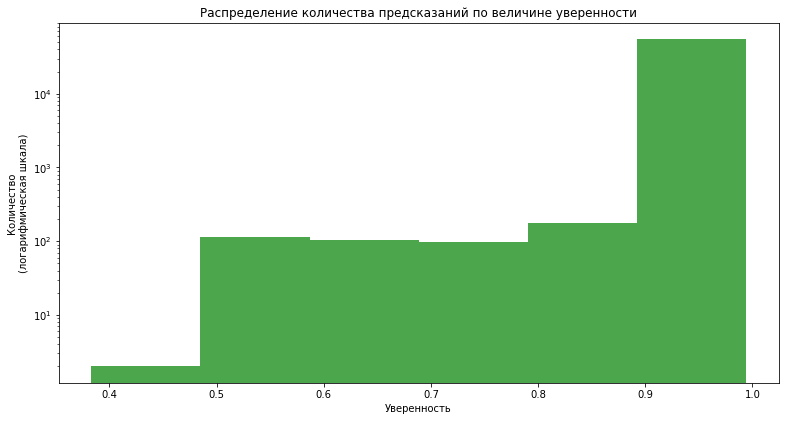

In [116]:
# Визуализируем
fig = plt.figure(figsize=(10,5))
axes = fig.add_axes([0, 0, 1, 1])
axes.hist(x = max_proba,
        bins = 6,
        color ='green',
        alpha = 0.7)
axes.set_title(f'Распределение количества предсказаний по величине уверенности')
plt.yscale('log')
plt.ylabel('Количество\n(логарифмическая шкала)')
plt.xlabel('Уверенность')
plt.show()

Разобьем выборку на несколько корзин и будем двигать границу "mid" между интервалами, вычисляя отношение количества элементов в интервале от [0, mid) к количеству элементов в интервале [mid, 1]. Это позволит численно оценить распределение количества предсказаний от величины вероятности предсказаний.

In [117]:
a = pd.Series(max_proba).value_counts(bins=8, ascending=False)
# Напечатать интервальную серию с выводом информации об отношении количества элементов в интервалах 
top = 1
bottom = 0
print(f"{'Интервал':>12} {'Количество':>8}")
for i in range(len(a)):
    mid = a.index[i].right
    s = f"{str(a.index[i]):>12} {a.values[i]:>10}"
    if i==0:
        print(s)
        continue
    print("{0} | кол. элементов в интервале ({1}, {2}] / кол. элементов в интервале ({2}, {3}] = {4:.2f}%" \
          .format(s, bottom, mid, top, a.iloc[i:].sum() / a.iloc[:i].sum() * 100))

    Интервал Количество
(0.918, 0.994]      54855
(0.841, 0.918]        181 | кол. элементов в интервале (0, 0.918] / кол. элементов в интервале (0.918, 1] = 1.05%
(0.765, 0.841]        106 | кол. элементов в интервале (0, 0.841] / кол. элементов в интервале (0.841, 1] = 0.71%
(0.612, 0.688]         84 | кол. элементов в интервале (0, 0.688] / кол. элементов в интервале (0.688, 1] = 0.52%
(0.536, 0.612]         69 | кол. элементов в интервале (0, 0.612] / кол. элементов в интервале (0.612, 1] = 0.37%
(0.688, 0.765]         67 | кол. элементов в интервале (0, 0.765] / кол. элементов в интервале (0.765, 1] = 0.24%
(0.459, 0.536]         66 | кол. элементов в интервале (0, 0.536] / кол. элементов в интервале (0.536, 1] = 0.12%
(0.382, 0.459]          1 | кол. элементов в интервале (0, 0.459] / кол. элементов в интервале (0.459, 1] = 0.00%


Выходит, что количество предсказаний с уверенностью от 0 до 0.918 составляет примерно 1% от количества предсказаний с уверенностью от 0.918 до 1.0. То есть модель демонстрирует серьезную уверенность на 99% предсказаний.

Но давайте проверим где эта уверенность может подвести. Посчитаем количество ошибочных предсказаний в определенных выше интервалах.

In [121]:
proba = pd.DataFrame(data=y_pred_proba,columns=rfc.classes_)
print('proba.shape',proba.shape)

def get_max_3_classes(row):
    """
    Получает серию из предсказаний размерностью n-классов и возвращает три класса с максимальной вероятностью
    и значания вероятности для этих классов.
    
    """
    ser = pd.Series(data=row.values, index=rfc.classes_)
    ser.sort_values(inplace=True, ascending=False)
    return ser[0:3].index[0],ser[0:3].values[0], \
        ser[0:3].index[1],ser[0:3].values[1], \
        ser[0:3].index[2],ser[0:3].values[2]

proba['top_1_class'], proba['top_1_proba'], \
    proba['top_2_class'], proba['top_2_proba'], \
    proba['top_3_class'], proba['top_3_proba'] = zip(*proba.apply(get_max_3_classes, axis=1))

proba['top_1_class'] = proba['top_1_class'].astype(int)
proba['top_2_class'] = proba['top_2_class'].astype(int)
proba['top_3_class'] = proba['top_3_class'].astype(int)

proba['y_valid'] = y_valid.values
proba['correct_1'] = proba.apply(lambda x: int(x.top_1_class==x.y_valid),axis=1)
proba['correct_2'] = proba.apply(lambda x: int(x.top_2_class==x.y_valid),axis=1)
proba['correct_3'] = proba.apply(lambda x: int(x.top_3_class==x.y_valid),axis=1)

# Оставим только новые столбцы с информацией по 3-м классам с наивысшей уверенностью
proba = proba.loc[:,'top_1_class':]
proba.head(3)

proba.shape (55429, 80)


,top_1_class,top_1_proba,top_2_class,top_2_proba,top_3_class,top_3_proba,y_valid,correct_1,correct_2,correct_3
0,10443876,0.990843,10398269,0.000150,10445233,0.000149,10443876,1,0,0
1,10401841,0.993352,10441605,0.000112,10445233,0.000104,10401841,1,0,0
2,10335966,0.993846,10407810,0.000250,10408126,0.000105,10335966,1,0,0


In [122]:
# Всего предсказаний
total = proba.shape[0]
# Количество верных предсказаний по классам 
corr_cl1 = proba[proba.top_1_class==proba.y_valid].shape[0]
corr_cl2 = proba[proba.top_2_class==proba.y_valid].shape[0]
corr_cl3 = proba[proba.top_3_class==proba.y_valid].shape[0]
not_correct = total - (corr_cl1 + corr_cl2 + corr_cl3)
print(f"""Всего предсказаний: {total}
Правильных предсказаний: {corr_cl1/total*100:.1f}% ({corr_cl1})
Предсказанных во втором варианте: {corr_cl2/total*100:.2f}% ({corr_cl2})
Предсказанных в третьем варианте: {corr_cl3/total*100:.3f}% ({corr_cl3})
Не предсказанных вообще {not_correct/total*100:.3f}% ({not_correct})
""")

def get_proba_info(class_num, proba_from, proba_to):
    """
    Получает название класса и возвращает количество правильных, не правильных ответов, а также интервал
    
    """
    correct_num = proba[(proba[class_num+'_class']==proba.y_valid)& \
        (proba[class_num+'_proba']>proba_from)&(proba[class_num+'_proba']<=proba_to)].shape[0]
    incorrect_num = proba[(proba[class_num+'_class']!=proba.y_valid)& \
        (proba[class_num+'_proba']>proba_from)&(proba[class_num+'_proba']<=proba_to)].shape[0]
    return correct_num, incorrect_num, (proba_from, proba_to)

correct, incorrect, index = [], [], []
for edge in range(20,100,10):
    cor, inc, ind = get_proba_info('top_1',edge/100,(edge+10)/100)
    correct.append(cor)
    incorrect.append(inc)
    index.append(ind)
    
a = pd.DataFrame(data={'correct':correct[::-1], 'incorrect':incorrect[::-1]}, index=index[::-1])    

# Напечатать интервальную серию с выводом информации об отношении количеств элементов в интервалах 
top = 1
bottom = 0
print(f"{'Интервал':>12} {'Верных':>8} {'Неверных':>10} {'Вер./Нев.':>11}")
for i in range(len(a)):
    mid = a.index[i][0]
    s = f"{str(a.index[i]):>12} {a.correct[i]:>8} {a.incorrect[i]:>10}"
    if i==0:
        v = a.incorrect[i] / (a.incorrect[i] + a.correct[i]) * 100
    else:
        v = a.incorrect[:i+1].sum() / (a.incorrect[:i+1].sum() + a.correct[:i+1].sum()) * 100
    print("{0} {1:>10.2f} | интервал ({2}, {3}] кол. ошибок / общему кол. предсказаний = {4:.2f}%" \
          .format(s, a.incorrect[i] / (a.incorrect[i] + a.correct[i]) * 100, mid, top, v))

Всего предсказаний: 55429
Правильных предсказаний: 99.3% (55033)
Предсказанных во втором варианте: 0.66% (364)
Предсказанных в третьем варианте: 0.038% (21)
Не предсказанных вообще 0.020% (11)

    Интервал   Верных   Неверных   Вер./Нев.
  (0.9, 1.0)    54680        235       0.43 | интервал (0.9, 1] кол. ошибок / общему кол. предсказаний = 0.43%
  (0.8, 0.9)      147         40      21.39 | интервал (0.8, 1] кол. ошибок / общему кол. предсказаний = 0.50%
  (0.7, 0.8)       65         29      30.85 | интервал (0.7, 1] кол. ошибок / общему кол. предсказаний = 0.55%
  (0.6, 0.7)       77         31      28.70 | интервал (0.6, 1] кол. ошибок / общему кол. предсказаний = 0.61%
  (0.5, 0.6)       59         57      49.14 | интервал (0.5, 1] кол. ошибок / общему кол. предсказаний = 0.71%
  (0.4, 0.5)        4          4      50.00 | интервал (0.4, 1] кол. ошибок / общему кол. предсказаний = 0.71%
  (0.3, 0.4)        1          0       0.00 | интервал (0.3, 1] кол. ошибок / общему кол. предс

Из проведенного анализа делаем вывод, что даже тогда, когда модель демонстрирует максимальную уверенность (интервал от 0.9 до 1.0), она ошибается в 0.47% случаев. По мере снижения уверенности относительное количество ошибок растет. Уже в интервале от 0.8 до 0.9 процент ошибочных предсказаний резко увеличивается до 21%.

Полученные данные были презентованы бизнесу и принято решение показывать в отчете топ-3 предсказания, при этом для первого предсказания отображать уверенность. Уверенность нужно отображать цветовой заливкой: если вероятность класса больше 0.9, то заливка зеленая, если больше 0.7, но меньше 0.9, то желтая. Красной заливкой обозначены все предсказания с определенной уверенностью ниже 0.7.

Кроме этого, подтвердили договоренность исключать из обучения и предсказания классы с количеством сэмплов меньше 25, при этом сообщать пользователю о таких классах.

## Выводы

В процессе выполнения работы входные данные были проанализированы и очищены. Был разработан алгоритм восстановления координат точек по координатам соседних точек (соседство определяется по адресам). Обнаружены скрытые пропущенные значения в иерархиях дистрибьюторов и сотрудников. Выполнен анализ пропущенных значений. Для ответа на вопросы о данных привлекался бизнес-аналитик со знанием предметной области.  

Выбрана метрика и классификатор для оценки для проведения экспериментов. Полученный набор данных является несбалансированным, поэтому для оценки модели было решено использовать метрику balanced accuracy score, которая учитывает несбалансированность классов.

Для обучения и валидации моделей была написана процедура упрощающая выполнение экспериментов и сохраняющая результаты в общую таблицу для последующего сравнения.

Проведены эксперименты с отбором признаков и анализ важности признаков. Определен набор признаков который показывает неплохие результаты с 2/3 признаков (от исходного количества). Однако лучший результат достигается использованием всех признаков для обучения.

Проанализирован целевой признак и подтверждена гипотеза о том, что классы с количеством сэмплов до 100 дают большую относительное количество ошибок.

Проведено исследование влияния пропущенных значений признаков-иерархий для класса на относительное количество ошибок. Влияние не подтверждено. Однако замечено, что удаление пропущенных ошибок дает лучшую точность.

Попробованы алгоритмы XGBoost и CatBoost для классификации. Полученая точность оказалась ниже RandomForestClassifier и LogisticRegression.

Произведен подбор GridSearchCV лучших параметров для RandomForestClassifier, LogisticRegression, KNeighborsClassifier. Проверена работа StackingClassifier и достигнута лучшая точность.

Полученные результаты валидации лучшего эстиматора были детально проанализированы. Было проверено распределение вероятности ответа от количества предсказаний и было обнаружено, что модель демонстрирует максимальную уверенность в 99% ответов. При этом анализ ошибок внутри каждого интервала уверенности показал, что относительная ошибка внутри интервала с максимальной уверенностью от 0.9 до 1.0 составляет 0.5%, но относительная ошибка быстро растет и уже в интервале уверенности от 0.8 до 0.9 она составляет 21%.

Полученные результаты были использованы при принятии решения о том, какую информацию будет получать пользователь. Было решено показывать пользователю топ 3 класса, при этом цветом отображать уверенность модели в предсказании ответа для 1-го класса: если вероятность предсказания больше 0.9, то заливка зеленая, если больше 0.7, но меньше 0.9, то желтая. Красной заливкой обозначены все предсказания с определенной уверенностью ниже 0.7.